In [76]:
import os
import pickle
import random
import time
from time import time
import typing
from typing import Union

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import mse_loss, l1_loss, binary_cross_entropy, cross_entropy
from torch.optim import Optimizer
from torch.utils.data import DataLoader

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [78]:
!pip install onnxruntime

In [79]:
import onnxruntime as ort
from collections import deque

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/tip.svg">
>   <img alt="Tip" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/tip.svg">
> </picture><br>
>
> ### Helpers & middlewares to measure metrics

In [80]:
class FpsWrapper:
    """ Decorator to calculate the frames per second of a function
    """
    def __init__(self, func: typing.Callable):
        self.func = func
        self.fps_list = deque([], maxlen=100)

    def __call__(self, *args, **kwargs):
        start = time.time()
        results = self.func(self.instance, *args, **kwargs)
        self.fps_list.append(1 / (time.time() - start))
        self.instance.fps = np.mean(self.fps_list)
        return results

    def __get__(self, instance, owner):
        self.instance = instance
        return self.__call__.__get__(instance, owner)


class OnnxInferenceModel:
    """ Base class for all inference models that use onnxruntime

    Attributes:
        model_path (str, optional): Path to the model folder. Defaults to "".
        force_cpu (bool, optional): Force the model to run on CPU or GPU. Defaults to GPU.
        default_model_name (str, optional): Default model name. Defaults to "model.onnx".
    """
    def __init__(
        self,
        model_path: str = "",
        force_cpu: bool = False,
        default_model_name: str = "model.onnx",
        *args, **kwargs
        ):
        self.model_path = model_path.replace("\\", "/")
        self.force_cpu = force_cpu
        self.default_model_name = default_model_name

        # check if model path is a directory with os path
        if os.path.isdir(self.model_path):
            self.model_path = os.path.join(self.model_path, self.default_model_name)

        if not os.path.exists(self.model_path):
            raise Exception(f"Model path ({self.model_path}) does not exist")

        providers = ["CUDAExecutionProvider", "CPUExecutionProvider"] if ort.get_device() == "GPU" and not force_cpu else ["CPUExecutionProvider"]

        self.model = ort.InferenceSession(self.model_path, providers=providers)

        self.metadata = {}
        if self.model.get_modelmeta().custom_metadata_map:
            # add metadata to self object
            for key, value in self.model.get_modelmeta().custom_metadata_map.items():
                try:
                    new_value = eval(value) # in case the value is a list or dict
                except:
                    new_value = value
                self.metadata[key] = new_value

        # Update providers priority to only CPUExecutionProvider
        if self.force_cpu:
            self.model.set_providers(["CPUExecutionProvider"])

        self.input_shapes = [meta.shape for meta in self.model.get_inputs()]
        self.input_names = [meta.name for meta in self.model._inputs_meta]
        self.output_names = [meta.name for meta in self.model._outputs_meta]

    def predict(self, data: np.ndarray, *args, **kwargs):
        raise NotImplementedError

    @FpsWrapper
    def __call__(self, data: np.ndarray):
        results = self.predict(data)
        return results

In [81]:
class PerformanceEvaluator:
    def __init__(self, model, dataset, device=None, batch_size=32):
        self.model = model.model if hasattr(model, 'model') else model
        self.dataset = dataset
        self.batch_size = batch_size
        self.data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        self.device = device
        self.model.to(self.device)

        # Measured performance metrics
        self.latency = None
        self.throughput = None
        self.model_size = None
        self.target_metrics = None

    def eval(self):

        result = dict(
            latency=self.measure_latency(),
            throughput=self.measure_throughput(),
            model_size=self.measure_model_size(),
        )

        self.report()
        return result

    def measure_latency(self, reps: int = 50):
        timings = np.zeros((reps, 1))
        if torch.cuda.is_available():
            self.warm_up_cuda()
        with torch.no_grad():
            with tqdm(total=reps, desc='Measuring latency', unit='rep') as pbar:
                for rep in range(reps):
                    for inputs, _ in self.data_loader:
                        start_time = time.time()
                        _ = self.model(inputs.to(self.device))
                        end_time = time.time()
                        if torch.cuda.is_available():
                            torch.cuda.synchronize()
                        curr_time = (end_time - start_time) * 1000
                        timings[rep] = curr_time / inputs.size(0)
                        break
                    pbar.update(1)
        self.latency = round(np.mean(timings) / reps, 5)
        return self.latency

    def measure_throughput(self, batches: int = 5):
        total_data_size = 0
        start_time = time.time()
        # measure for n batches
        with torch.no_grad():
            with tqdm(total=batches, desc='Measuring throughput', unit='batch') as pbar:
                for inputs, _ in self.data_loader:
                    inputs = inputs.to(self.device)
                    if batches == 0:
                        break
                    total_data_size += inputs.size(0)
                    _ = self.model(inputs)
                    batches -= 1
                    pbar.update(1)
        if self.device == 'cuda':
            torch.cuda.synchronize()
        total_time = (time.time() - start_time) / 1000
        self.throughput = round(total_data_size / total_time, 0)
        return self.throughput

    def measure_model_size(self):
        if isinstance(self.model, OnnxInferenceModel): # ONNXInferenceModel
            size_all_mb = round(self.model.size(), 3) / 1024 ** 2
        else:
            param_size = 0
            for param in self.model.parameters():
                param_size += param.nelement() * param.element_size()
            buffer_size = 0
            for buffer in self.model.buffers():
                buffer_size += buffer.nelement() * buffer.element_size()

            size_all_mb = (param_size + buffer_size) / 1024 ** 2
        self.model_size = round(size_all_mb, 3)
        return self.model_size

    def warm_up_cuda(self, num_iterations=10):
        """Warm up CUDA by performing some dummy computations"""
        if torch.cuda.is_available():
            for _ in range(num_iterations):
                inputs, _ = next(iter(self.data_loader))
                inputs = inputs.to(self.device)
                _ = self.model(inputs)

    def report(self):
        print(f"Latency: {self.latency} ms/sample with batch_size {self.batch_size}")
        print(f"Throughput: {self.throughput} samples/s with batch_size {self.batch_size}")
        print(f"Model size: {self.model_size} MB")

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/tip.svg">
>   <img alt="Tip" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/tip.svg">
> </picture><br>
>
> ### Helper for dataset import

In [86]:
import csv
def get_m4_data(backcast_length, forecast_length, is_training=True):
    # https://www.mcompetitions.unic.ac.cy/the-dataset/

    if is_training:
        filename = 'Daily-train.csv'
    else:
        filename = 'Daily-test.csv'

    x = np.array([]).reshape(0, backcast_length)
    y = np.array([]).reshape(0, forecast_length)
    x_tl = []
    headers = True
    with open(filename, "r") as file:
        reader = csv.reader(file, delimiter=',')
        for line in reader:
            line = line[1:]
            if not headers:
                x_tl.append(line)
            if headers:
                headers = False
    x_tl_tl = np.array(x_tl)
    for i in range(x_tl_tl.shape[0]):
        if len(x_tl_tl[i]) < backcast_length + forecast_length:
            continue
        time_series = np.array(x_tl_tl[i])
        time_series = [float(s) for s in time_series if s != '']
        time_series_cleaned = np.array(time_series)
        if is_training:
            time_series_cleaned_forlearning_x = np.zeros((1, backcast_length))
            time_series_cleaned_forlearning_y = np.zeros((1, forecast_length))
            j = np.random.randint(backcast_length, time_series_cleaned.shape[0] + 1 - forecast_length)
            time_series_cleaned_forlearning_x[0, :] = time_series_cleaned[j - backcast_length: j]
            time_series_cleaned_forlearning_y[0, :] = time_series_cleaned[j:j + forecast_length]
        else:
            time_series_cleaned_forlearning_x = np.zeros(
                (time_series_cleaned.shape[0] + 1 - (backcast_length + forecast_length), backcast_length))
            time_series_cleaned_forlearning_y = np.zeros(
                (time_series_cleaned.shape[0] + 1 - (backcast_length + forecast_length), forecast_length))
            for j in range(backcast_length, time_series_cleaned.shape[0] + 1 - forecast_length):
                time_series_cleaned_forlearning_x[j - backcast_length, :] = time_series_cleaned[j - backcast_length:j]
                time_series_cleaned_forlearning_y[j - backcast_length, :] = time_series_cleaned[j: j + forecast_length]
        x = np.vstack((x, time_series_cleaned_forlearning_x))
        y = np.vstack((y, time_series_cleaned_forlearning_y))

    return x, y

## Models

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/check.svg">
>   <img alt="Check" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/check.svg">
> </picture><br>
>
> ## NBeats architecture No Lora

In [82]:
class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = "seasonality"
    TREND_BLOCK = "trend"
    GENERIC_BLOCK = "generic"

    def __init__(
            self,
            device=torch.device("cpu"),
            stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
            nb_blocks_per_stack=3,
            forecast_length=5,
            backcast_length=10,
            thetas_dim=(4, 8),
            share_weights_in_stack=False,
            hidden_layer_units=256,
            nb_harmonics=None
    ):
        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dim
        self.parameters = []
        self.device = device
        print('| N-Beats')
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)
        self._loss = None
        self._opt = None
        self._gen_intermediate_outputs = False
        self._intermediary_outputs = []

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    self.hidden_layer_units, self.thetas_dim[stack_id],
                    self.device, self.backcast_length, self.forecast_length,
                    self.nb_harmonics
                )
                self.parameters.extend(block.parameters())
            print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    def disable_intermediate_outputs(self):
        self._gen_intermediate_outputs = False

    def enable_intermediate_outputs(self):
        self._gen_intermediate_outputs = True

    def save(self, filename: str):
        torch.save(self, filename)

    @staticmethod
    def load(f, map_location=None, pickle_module=pickle, **pickle_load_args):
        return torch.load(f, map_location, pickle_module, **pickle_load_args)

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def compile(self, loss: str, optimizer: Union[str, Optimizer]):
        if loss == 'mae':
            loss_ = l1_loss
        elif loss == 'mse':
            loss_ = mse_loss
        elif loss == 'cross_entropy':
            loss_ = cross_entropy
        elif loss == 'binary_crossentropy':
            loss_ = binary_cross_entropy
        else:
            raise ValueError(f'Unknown loss name: {loss}.')
        # noinspection PyArgumentList
        if isinstance(optimizer, str):
            if optimizer == 'adam':
                opt_ = optim.Adam
            elif optimizer == 'sgd':
                opt_ = optim.SGD
            elif optimizer == 'rmsprop':
                opt_ = optim.RMSprop
            else:
                raise ValueError(f'Unknown opt name: {optimizer}.')
            opt_ = opt_(lr=1e-4, params=self.parameters())
        else:
            opt_ = optimizer
        self._opt = opt_
        self._loss = loss_

    def fit(self, x_train, y_train, validation_data=None, epochs=10, batch_size=32):

        def split(arr, size):
            arrays = []
            while len(arr) > size:
                slice_ = arr[:size]
                arrays.append(slice_)
                arr = arr[size:]
            arrays.append(arr)
            return arrays

        for epoch in range(epochs):
            x_train_list = split(x_train, batch_size)
            y_train_list = split(y_train, batch_size)
            assert len(x_train_list) == len(y_train_list)
            shuffled_indices = list(range(len(x_train_list)))
            random.shuffle(shuffled_indices)
            self.train()
            train_loss = []
            timer = time()
            for batch_id in shuffled_indices:
                batch_x, batch_y = x_train_list[batch_id], y_train_list[batch_id]
                self._opt.zero_grad()
                _, forecast = self(torch.tensor(batch_x, dtype=torch.float).to(self.device))
                loss = self._loss(forecast, squeeze_last_dim(torch.tensor(batch_y, dtype=torch.float).to(self.device)))
                train_loss.append(loss.item())
                loss.backward()
                self._opt.step()
            elapsed_time = time() - timer
            train_loss = np.mean(train_loss)

            test_loss = '[undefined]'
            if validation_data is not None:
                x_test, y_test = validation_data
                self.eval()
                _, forecast = self(torch.tensor(x_test, dtype=torch.float).to(self.device))
                test_loss = self._loss(forecast, squeeze_last_dim(torch.tensor(y_test, dtype=torch.float))).item()

            num_samples = len(x_train_list)
            time_per_step = int(elapsed_time / num_samples * 1000)
            print(f'Epoch {str(epoch + 1).zfill(len(str(epochs)))}/{epochs}')
            print(f'{num_samples}/{num_samples} [==============================] - '
                  f'{int(elapsed_time)}s {time_per_step}ms/step - '
                  f'loss: {train_loss:.4f} - val_loss: {test_loss:.4f}')

    def predict(self, x, return_backcast=False):
        self.eval()
        b, f = self(torch.tensor(x, dtype=torch.float).to(self.device))
        b, f = b.detach().numpy(), f.detach().numpy()
        if len(x.shape) == 3:
            b = np.expand_dims(b, axis=-1)
            f = np.expand_dims(f, axis=-1)
        if return_backcast:
            return b
        return f

    @staticmethod
    def name():
        return 'NBeatsPytorch'

    def get_generic_and_interpretable_outputs(self):
        g_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' in a['layer'].lower()])
        i_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' not in a['layer'].lower()])
        outputs = {o['layer']: o['value'][0] for o in self._intermediary_outputs}
        return g_pred, i_pred, outputs

    def forward(self, backcast):
        self._intermediary_outputs = []
        backcast = squeeze_last_dim(backcast)
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
                block_type = self.stacks[stack_id][block_id].__class__.__name__
                layer_name = f'stack_{stack_id}-{block_type}_{block_id}'
                if self._gen_intermediate_outputs:
                    self._intermediary_outputs.append({'value': f.detach().numpy(), 'layer': layer_name})
        return backcast, forecast


def squeeze_last_dim(tensor):
    if len(tensor.shape) == 3 and tensor.shape[-1] == 1:  # (128, 10, 1) => (128, 10).
        return tensor[..., 0]
    return tensor


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor(np.array([np.cos(2 * np.pi * i * t) for i in range(p1)])).float()  # H/2-1
    s2 = torch.tensor(np.array([np.sin(2 * np.pi * i * t) for i in range(p2)])).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor(np.array([t ** i for i in range(p)])).float()
    return thetas.mm(T.to(device))


def linear_space(backcast_length, forecast_length, is_forecast=True):
    horizon = forecast_length if is_forecast else backcast_length
    return np.arange(0, horizon) / horizon


class Block(nn.Module):
    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False,
                 nb_harmonics=None):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace = linear_space(backcast_length, forecast_length, is_forecast=False)
        self.forecast_linspace = linear_space(backcast_length, forecast_length, is_forecast=True)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = squeeze_last_dim(x)
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlock(Block):
    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlock(Block):
    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlock, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class GenericBlock(Block):
    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(GenericBlock, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = self.theta_b_fc(x)
        theta_f = self.theta_f_fc(x)

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast

In [83]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

In [85]:
forecast_length = 5
backcast_length = 3 * forecast_length
batch_size = 10  # greater than 4 for viz

In [87]:
# data backcast/forecast generation.
x, y = get_m4_data(backcast_length, forecast_length)

In [88]:
# split train/test.
c = int(len(x) * 0.8)
x_train, y_train = x[:c], y[:c]
x_test, y_test = x[c:], y[c:]

# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant

In [89]:
# model
net_no_lora = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    hidden_layer_units=128,
)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @134804133795712
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @134804133794512
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @134804133799312
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @134804133794608
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @134804133799072
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @134804133791968


In [90]:
def train(network, no_lora):
    optimiser = optim.Adam(lr=1e-4, params=network.parameters())

    grad_step = 0
    for epoch in range(1000):
        # train.
        network.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = network(torch.tensor(x_train_batch, dtype=torch.float).to(network.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(network.device))
            train_loss.append(loss.item())

            if no_lora:
                loss.backward()
            optimiser.step()

        train_loss = np.mean(train_loss)

        # test.
        network.eval()
        _, forecast = network(torch.tensor(x_test, dtype=torch.float))
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            plt.subplots(figsize=(8, 8))
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='#000000')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='#1535f3')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='#b512b8')
            plt.show()


            print(
                f'epoch = {str(epoch).zfill(4)}, '
                f'grad_step = {str(grad_step).zfill(6)}, '
                f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                f'te_loss (epoch) = {1000 * test_loss:.3f}'
            )

## Train

<ipython-input-90-f231318e5714>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(subplots[plot_id])


<Figure size 640x480 with 0 Axes>

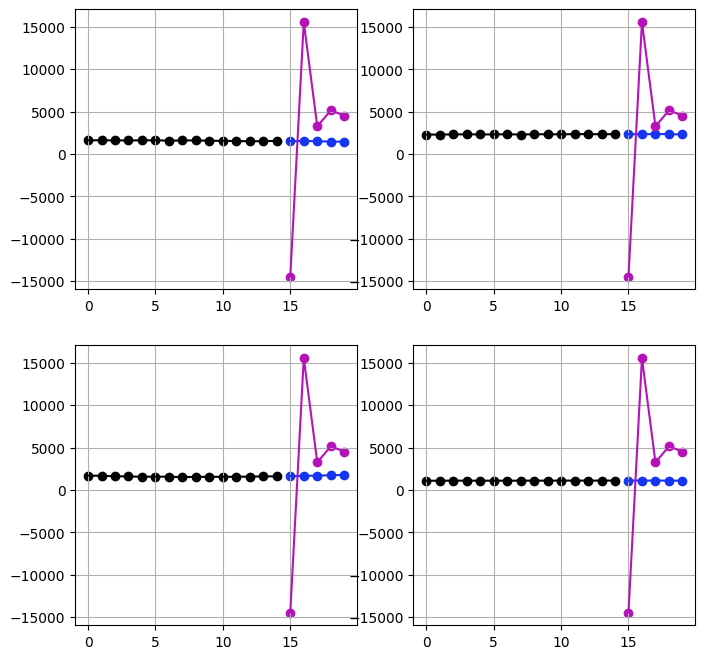

epoch = 0000, grad_step = 000008, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

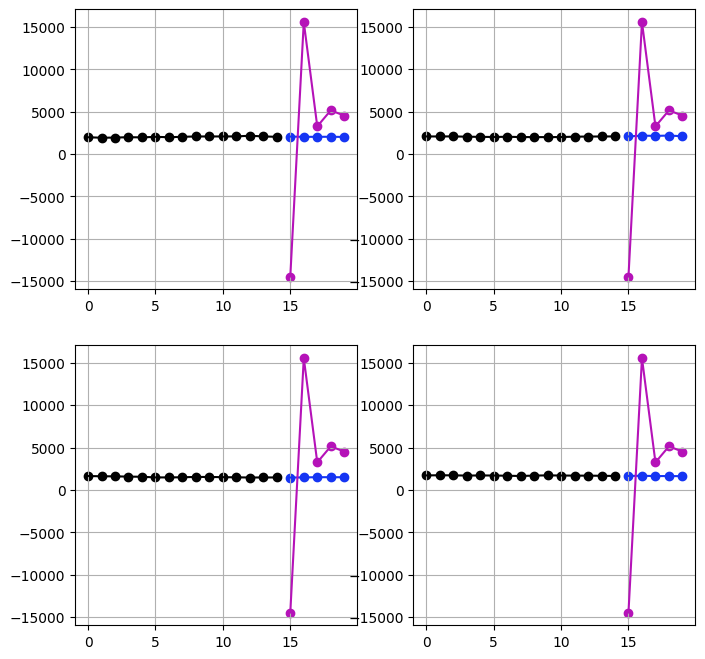

epoch = 0100, grad_step = 000808, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

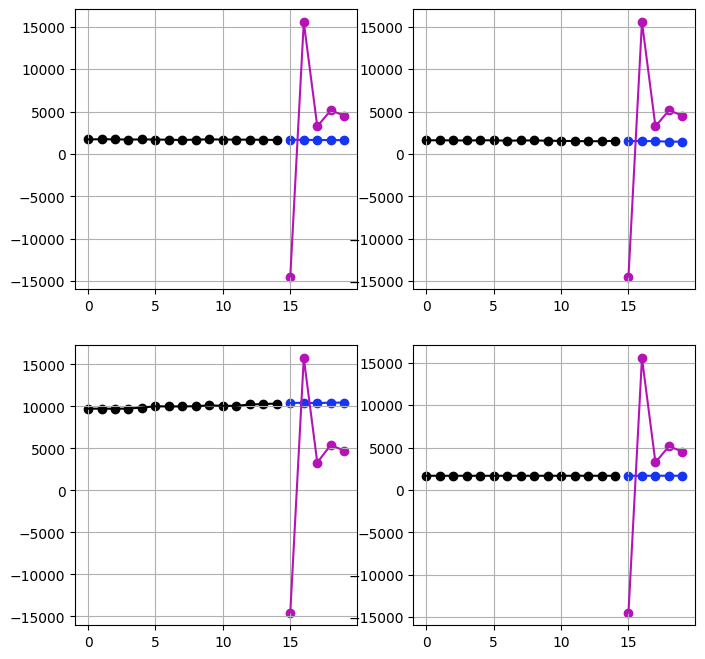

epoch = 0200, grad_step = 001608, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

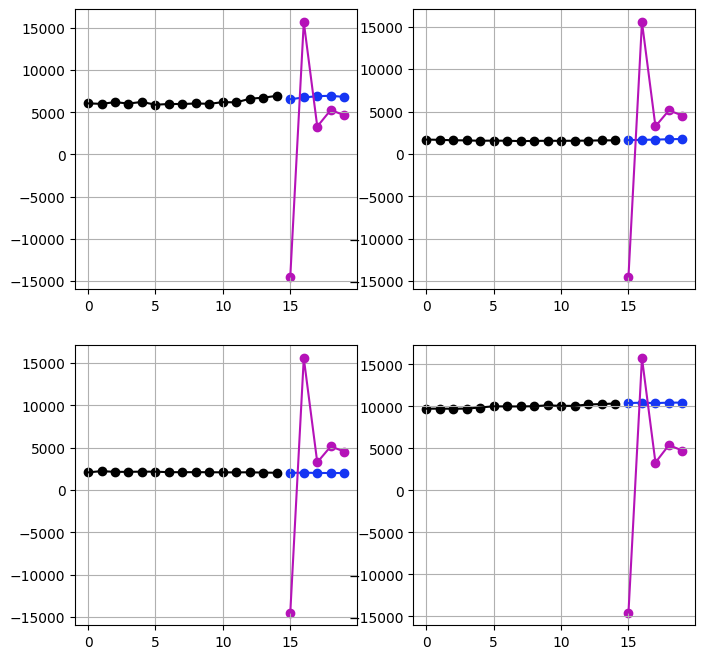

epoch = 0300, grad_step = 002408, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

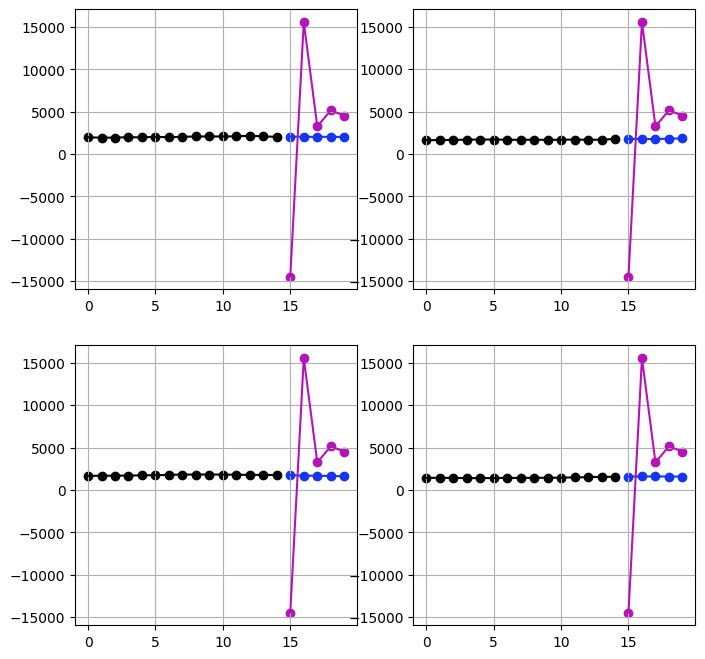

epoch = 0400, grad_step = 003208, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

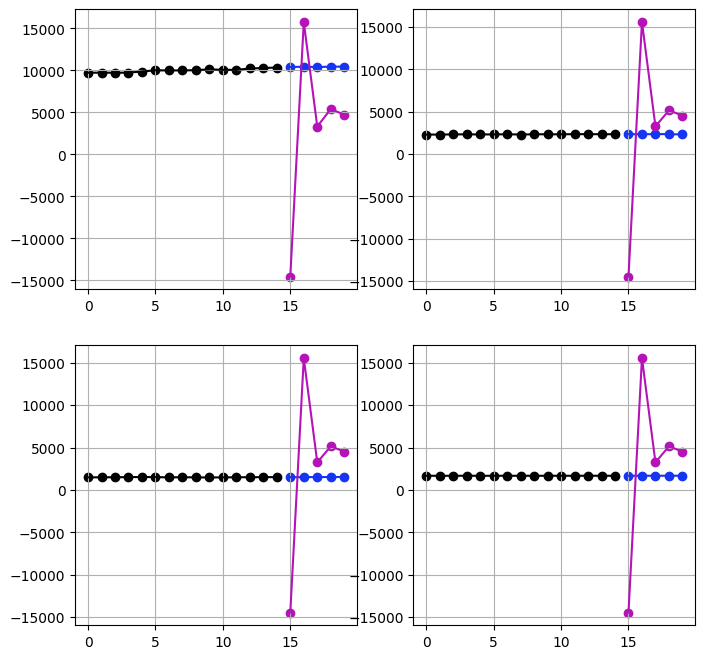

epoch = 0500, grad_step = 004008, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

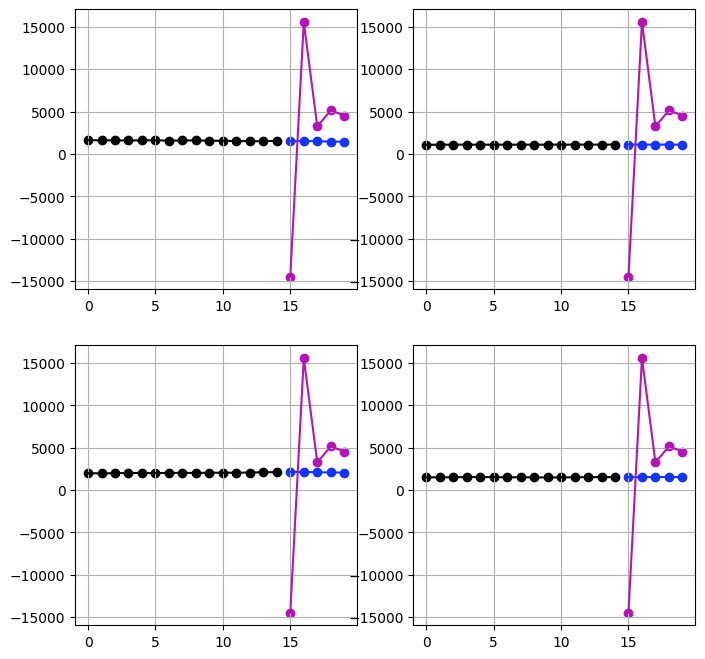

epoch = 0600, grad_step = 004808, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

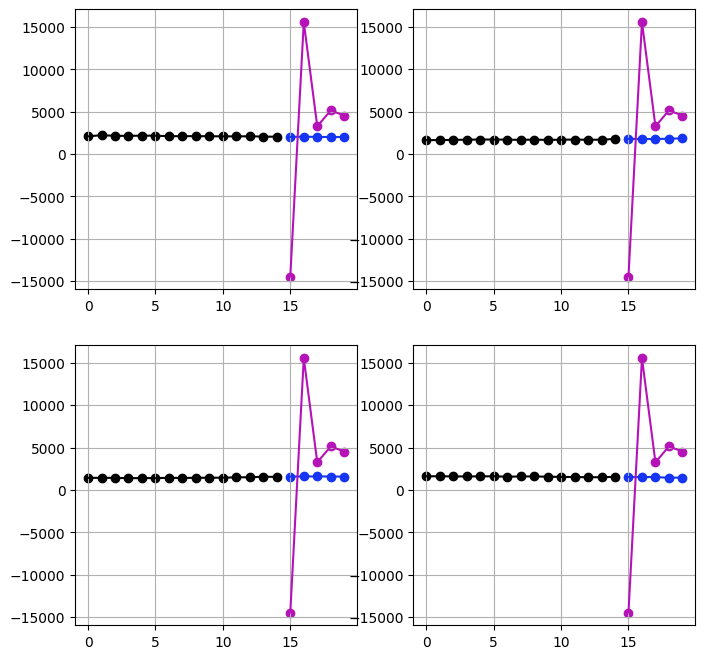

epoch = 0700, grad_step = 005608, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

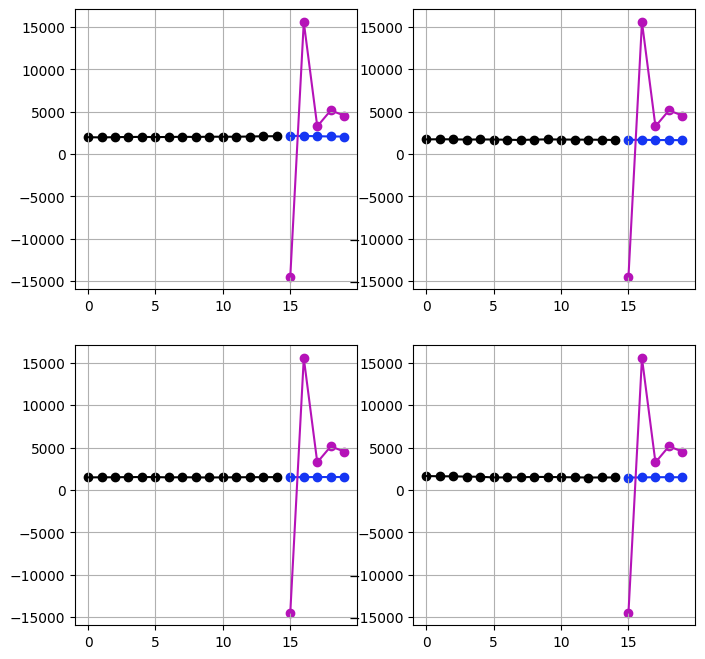

epoch = 0800, grad_step = 006408, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

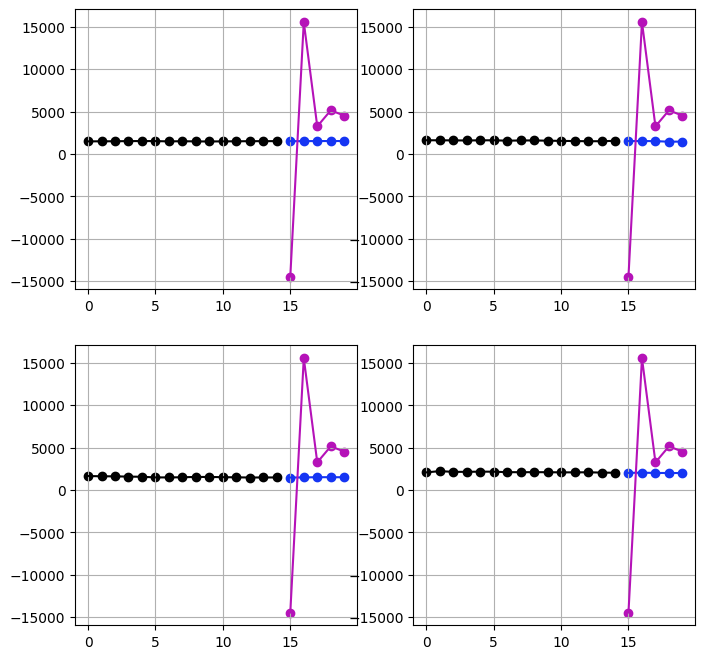

epoch = 0900, grad_step = 007208, tr_loss (epoch) = 399.741, te_loss (epoch) = 382.730


In [91]:
train(net_no_lora, False)

In [92]:
train_df = pd.read_csv("Daily-train.csv")
train_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V991,V992,V993,V994,V995,V996,V997,V998,V999,V1000
0,D1,1017.10,1019.30,1017.00,1019.20,1018.70,1015.60,1018.50,1018.30,1018.4,...,2001.1,2002.7,2004.1,2004.3,2016.4,2016.5,2021.1,2008.2,2002.9,2012.6
1,D2,2793.70,2793.80,2803.70,2805.80,2802.30,2795.00,2806.40,2782.20,2780.3,...,3042.7,3053.7,3074.9,3042.4,3034.0,3023.8,3019.6,3033.7,3040.2,3035.3
2,D3,1091.30,1088.50,1085.70,1082.90,1080.10,1077.30,1074.50,1071.70,1068.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D4,1092.00,1078.00,1064.00,1050.00,1036.00,1022.00,1008.00,1092.00,1078.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D5,2938.63,2956.44,2964.41,2972.41,3014.97,3014.23,3024.08,3031.97,3062.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))


> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/example.svg">
>   <img alt="Example" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/example.svg">
> </picture><br>
>
> #### Measure of metrics no lora metrics

In [94]:
pfev = PerformanceEvaluator(
    model=net_no_lora,
    dataset=train_dataset,
    device=device,
)

pfev.eval()

Measuring throughput:  60%|██████    | 3/5 [00:00<00:00, 384.96batch/s]

Latency: 0.00108 ms/sample with batch_size 32
Throughput: 4364808.0 samples/s with batch_size 32
Model size: 1.219 MB


{'latency': 0.00108, 'throughput': 4364808.0, 'model_size': 1.219}

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/info.svg">
>   <img alt="Info" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/info.svg">
> </picture><br>
>
> #### Compare with Microsoft Lora Implementation same model

In [96]:
!pip install loralib

In [97]:
import loralib as lora

<ipython-input-98-2510c7784f07>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(subplots[plot_id])


<Figure size 640x480 with 0 Axes>

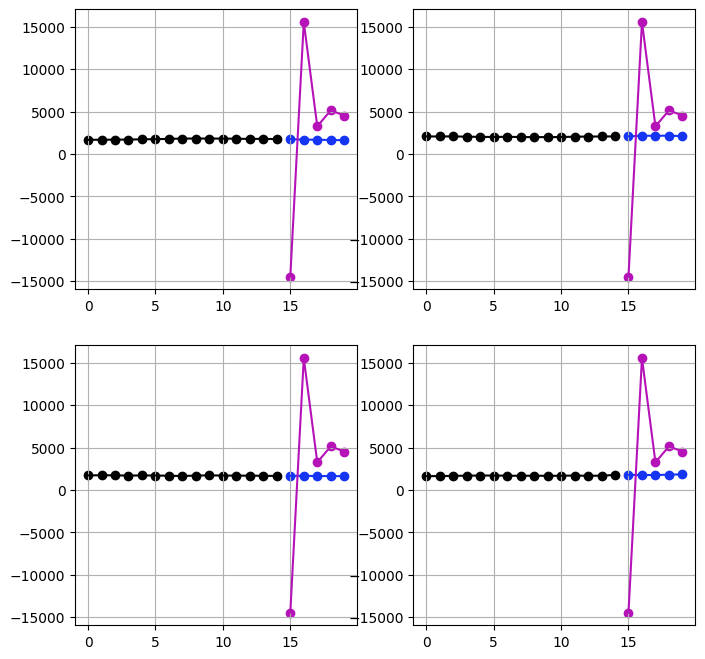

epoch = 0000, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

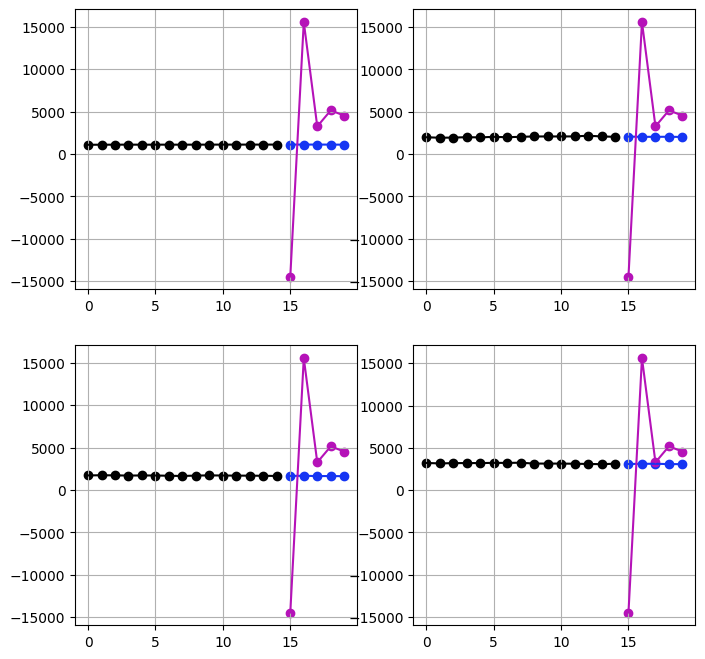

epoch = 0100, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

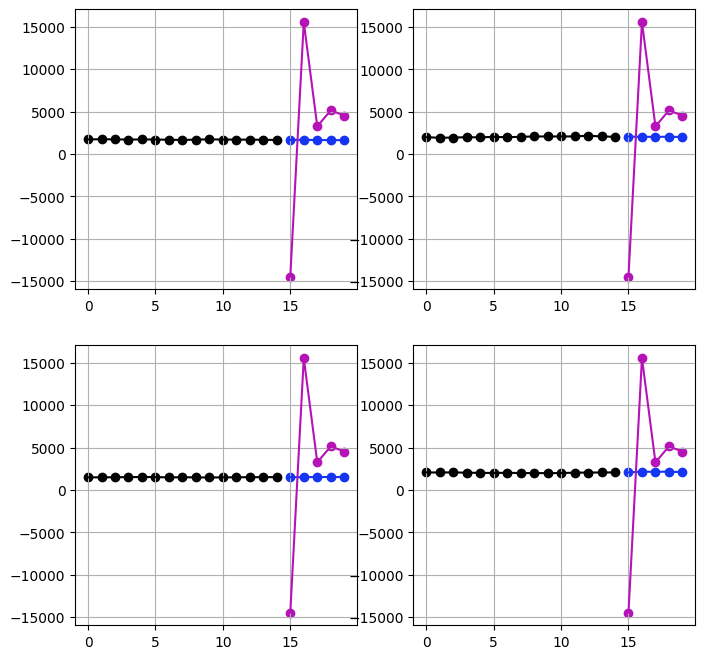

epoch = 0200, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

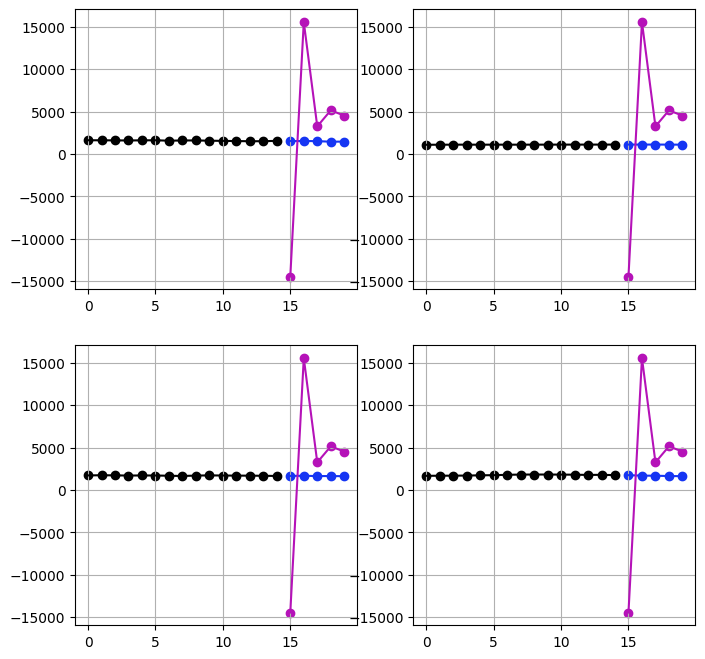

epoch = 0300, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

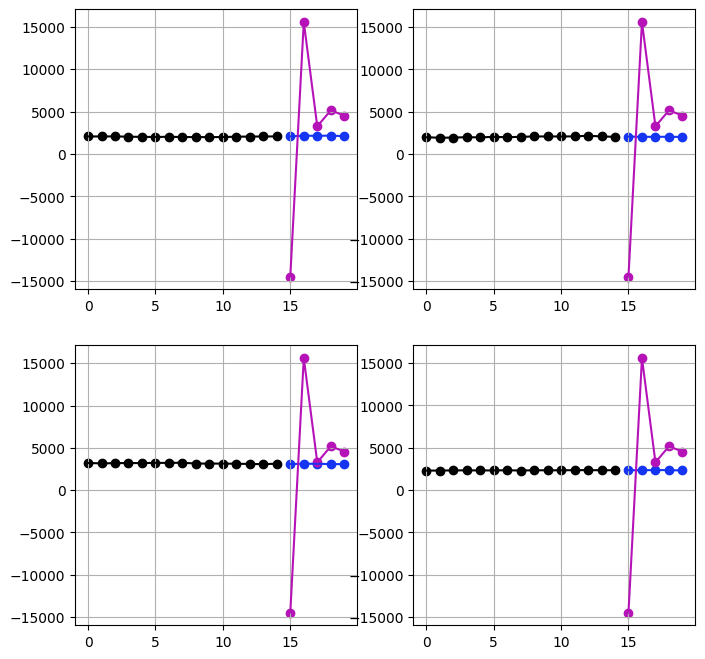

epoch = 0400, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

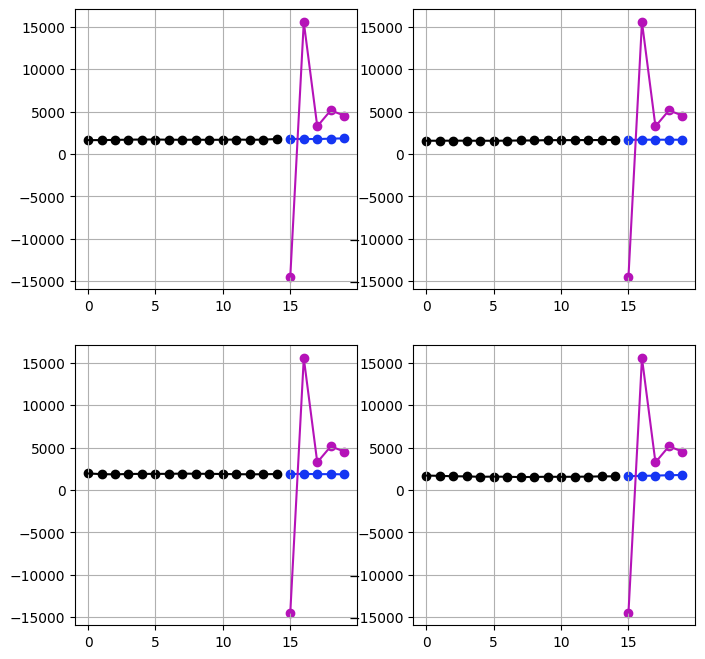

epoch = 0500, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

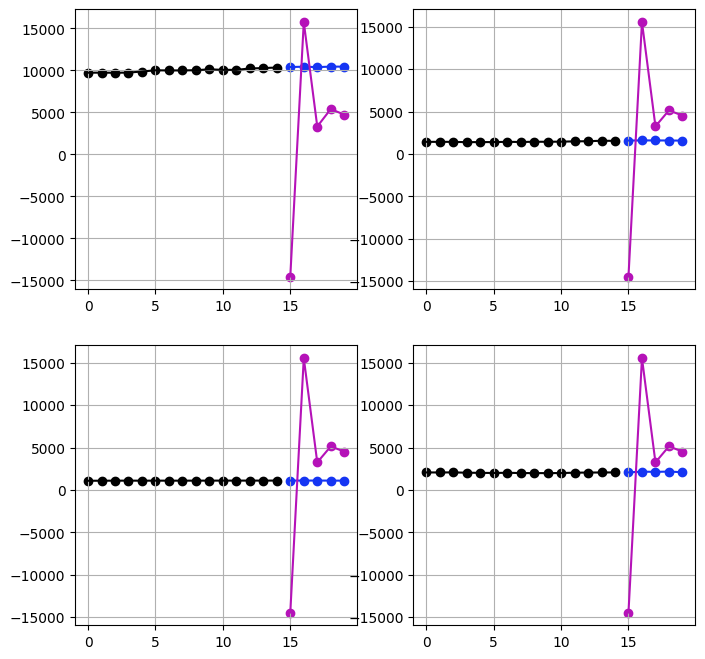

epoch = 0600, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

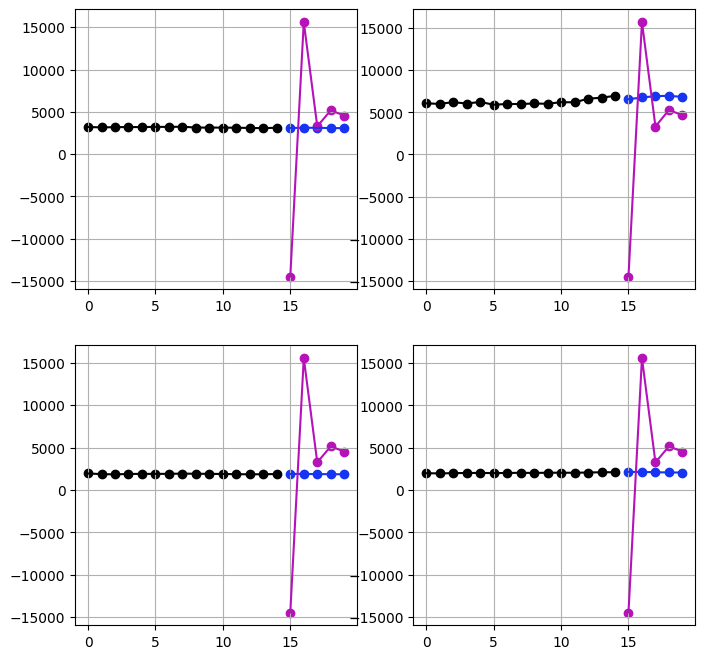

epoch = 0700, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

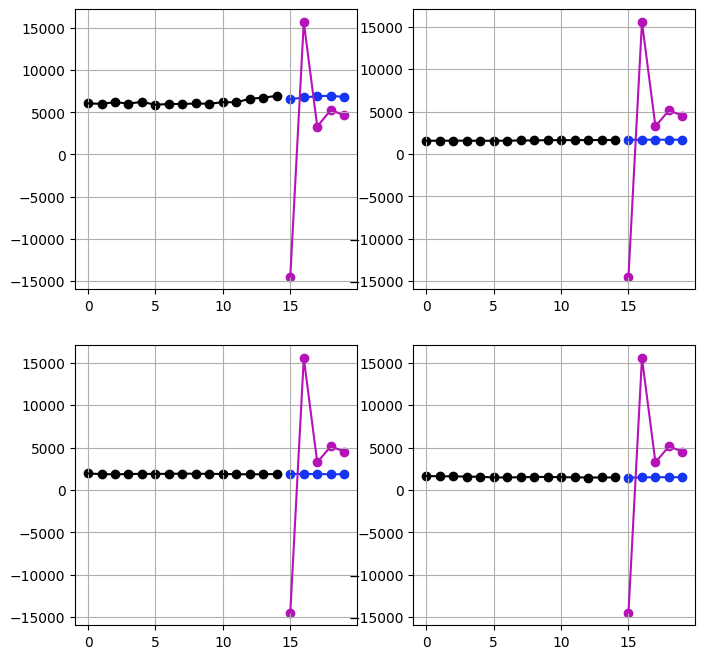

epoch = 0800, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

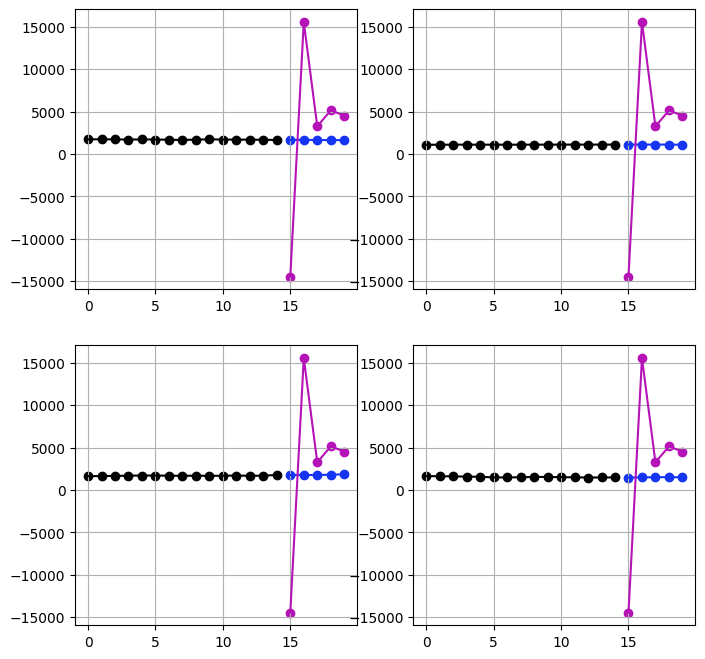

epoch = 0900, te_loss (epoch) = 382.730


In [98]:
# Training all bias vectors associated with modules we apply LoRA to
lora.mark_only_lora_as_trainable(net_no_lora)

for epoch in range(1000):
    net_no_lora.eval()
    _, forecast = net_no_lora(torch.tensor(x_test, dtype=torch.float))
    test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
    p = forecast.detach().numpy()
    if epoch % 100 == 0:
        subplots = [221, 222, 223, 224]
        plt.figure(1)
        plt.subplots(figsize=(8, 8))
        for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
            ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
            plt.subplot(subplots[plot_id])
            plt.grid()
            plot_scatter(range(0, backcast_length), xx, color='#000000')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='#1535f3')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='#b512b8')
        plt.show()


        print(
            f'epoch = {str(epoch).zfill(4)}, '
            f'te_loss (epoch) = {1000 * test_loss:.3f}'
        )

In [99]:
pfev2 = PerformanceEvaluator(
    model=net_no_lora,
    dataset=train_dataset,
    device=device,
)

pfev2.eval()

Measuring throughput:  60%|██████    | 3/5 [00:00<00:00, 292.47batch/s]

Latency: 0.00106 ms/sample with batch_size 32
Throughput: 4748564.0 samples/s with batch_size 32
Model size: 1.219 MB


{'latency': 0.00106, 'throughput': 4748564.0, 'model_size': 1.219}

<ipython-input-109-f2235d9fc8a7>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(subplots[plot_id])


<Figure size 640x480 with 0 Axes>

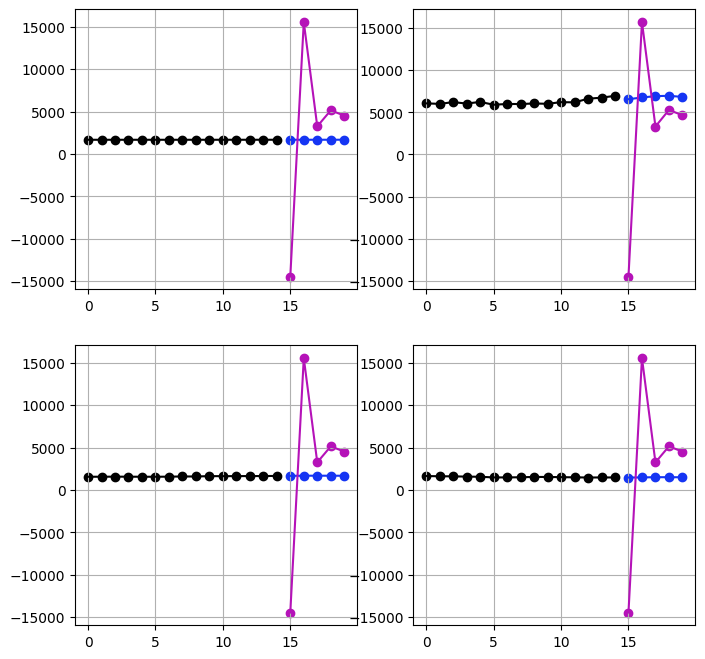

epoch = 0000, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

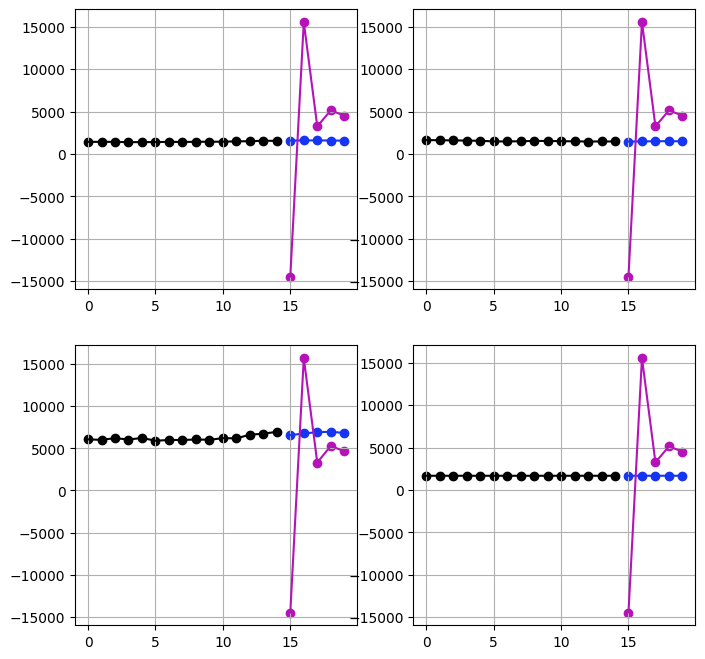

epoch = 0100, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

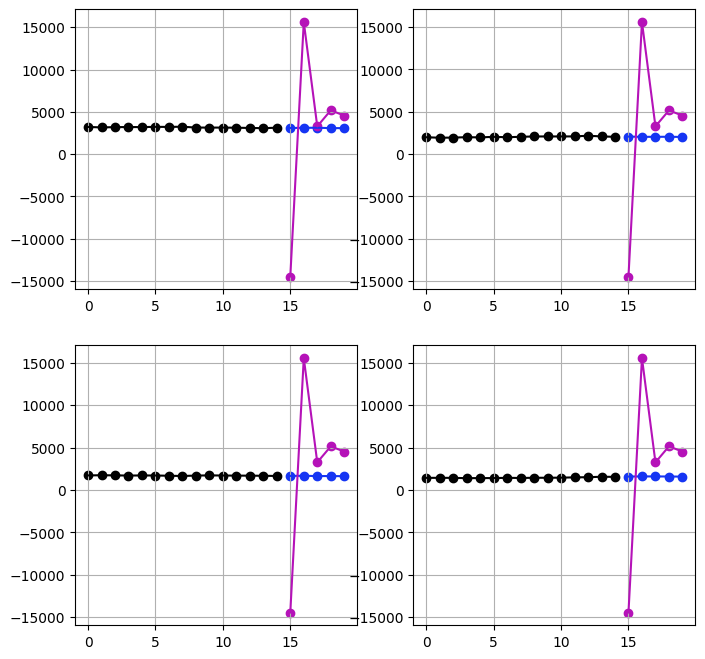

epoch = 0200, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

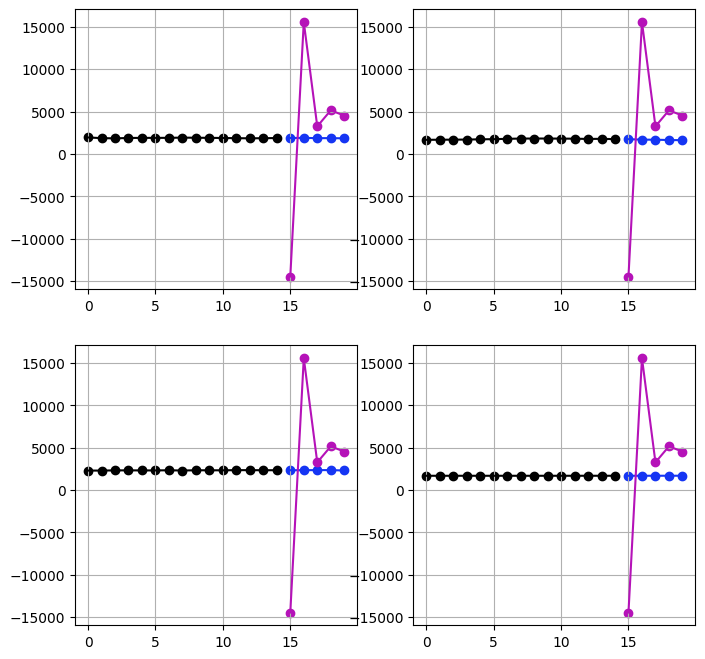

epoch = 0300, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

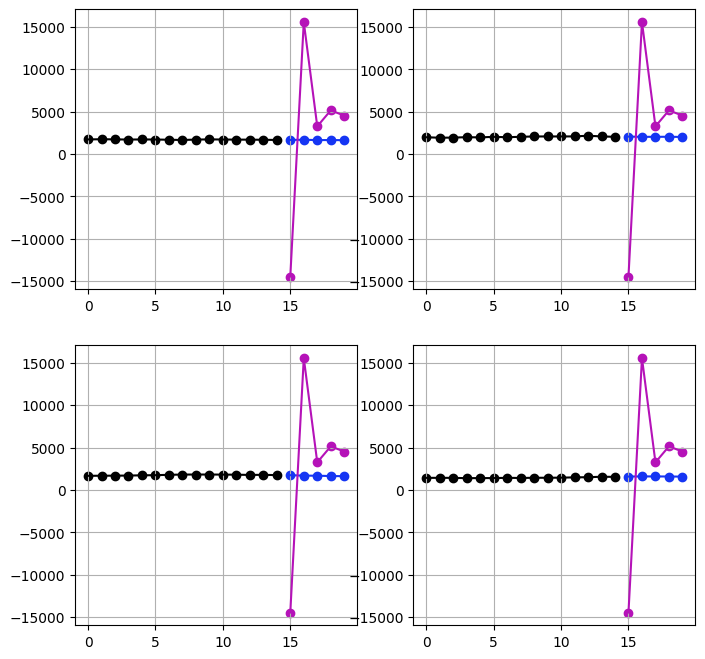

epoch = 0400, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

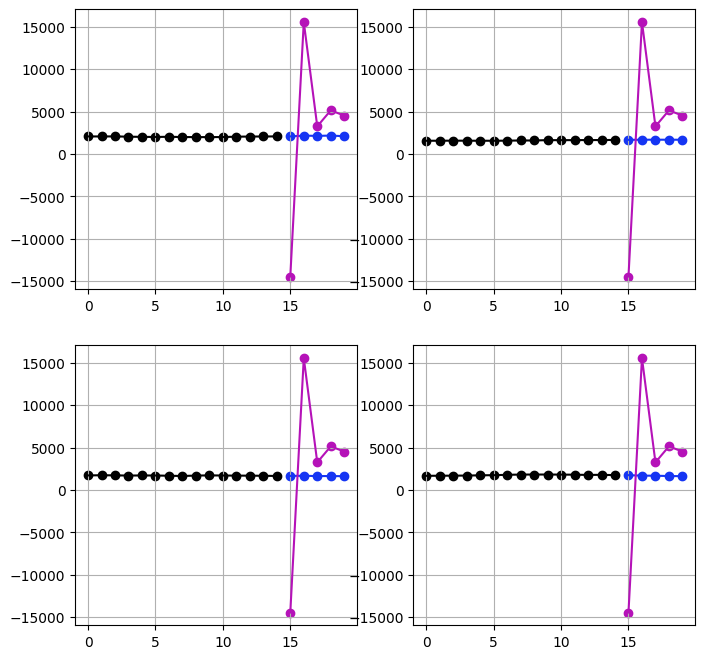

epoch = 0500, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

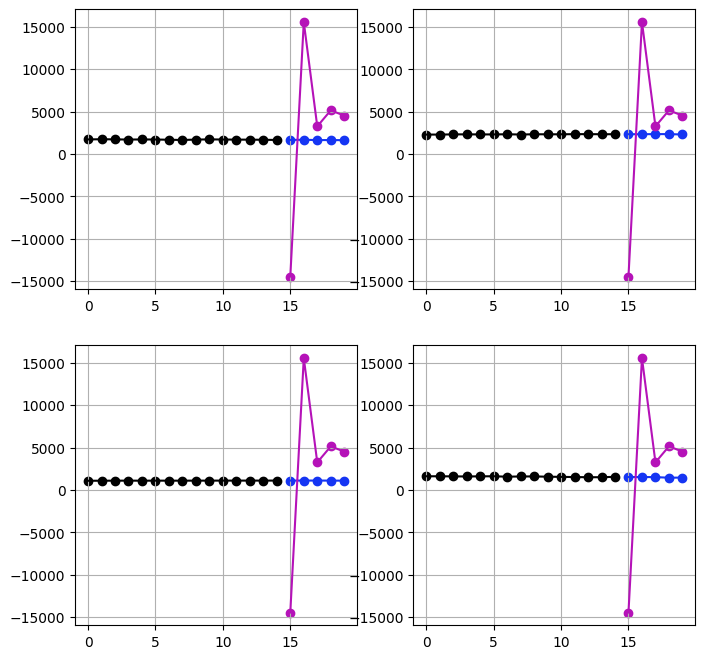

epoch = 0600, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

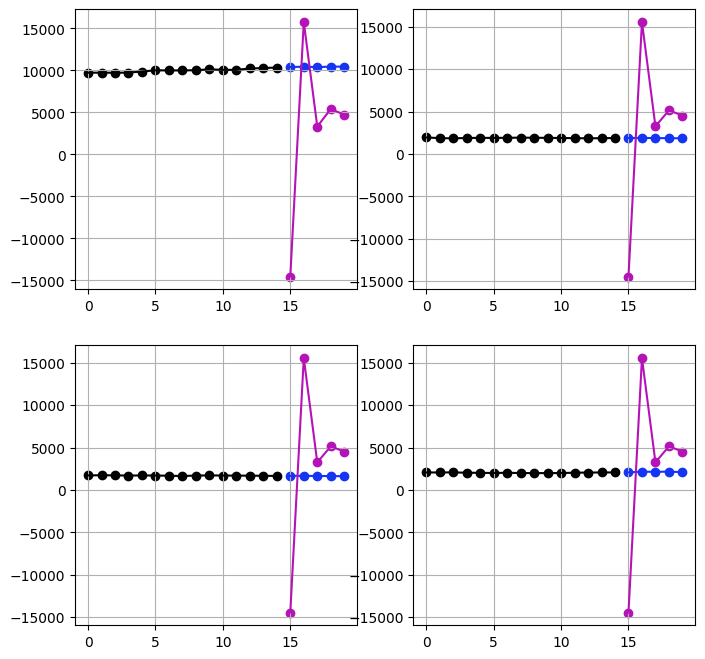

epoch = 0700, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

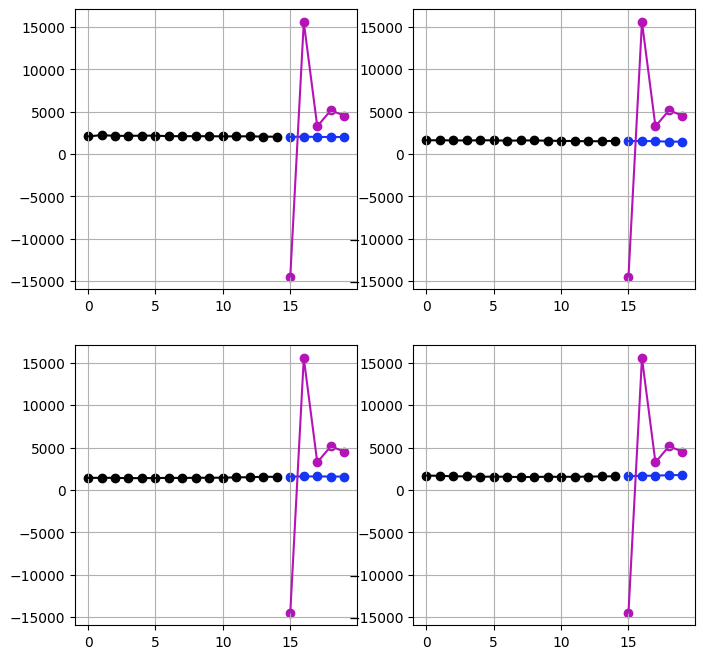

epoch = 0800, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

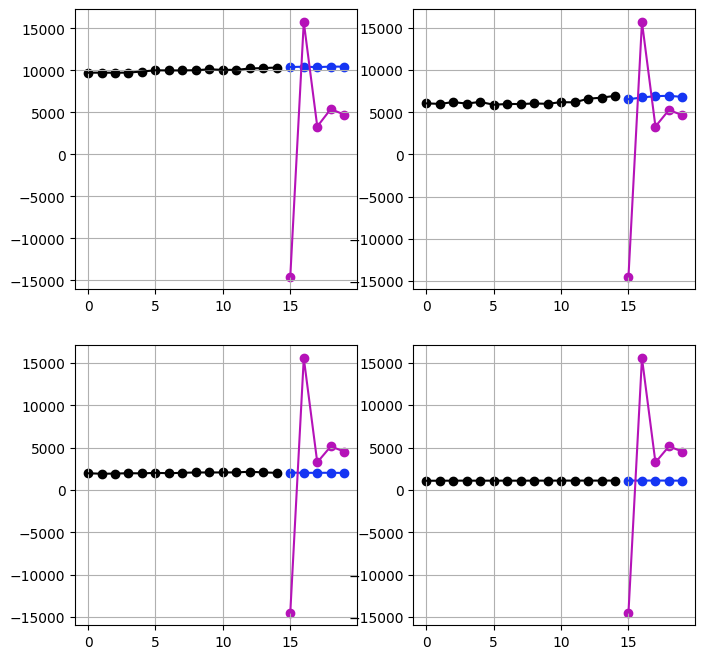

epoch = 0900, te_loss (epoch) = 382.730


In [109]:
# Alternatively, we can train *all* bias vectors in the model, including LayerNorm biases
lora.mark_only_lora_as_trainable(net_no_lora, bias='all')
for epoch in range(1000):
    net_no_lora.eval()
    _, forecast = net_no_lora(torch.tensor(x_test, dtype=torch.float))
    test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
    p = forecast.detach().numpy()
    if epoch % 100 == 0:
        subplots = [221, 222, 223, 224]
        plt.figure(1)
        plt.subplots(figsize=(8, 8))
        for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
            ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
            plt.subplot(subplots[plot_id])
            plt.grid()
            plot_scatter(range(0, backcast_length), xx, color='#000000')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='#1535f3')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='#b512b8')
        plt.show()


        print(
            f'epoch = {str(epoch).zfill(4)}, '
            f'te_loss (epoch) = {1000 * test_loss:.3f}'
        )

In [110]:
pfev4 = PerformanceEvaluator(
    model=net_no_lora,
    dataset=train_dataset,
    device=device,
)

pfev4.eval()

Measuring throughput:  60%|██████    | 3/5 [00:00<00:00, 299.90batch/s]

Latency: 0.00108 ms/sample with batch_size 32
Throughput: 4482670.0 samples/s with batch_size 32
Model size: 1.219 MB


{'latency': 0.00108, 'throughput': 4482670.0, 'model_size': 1.219}

<ipython-input-101-2dedf332f68a>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(subplots[plot_id])


<Figure size 640x480 with 0 Axes>

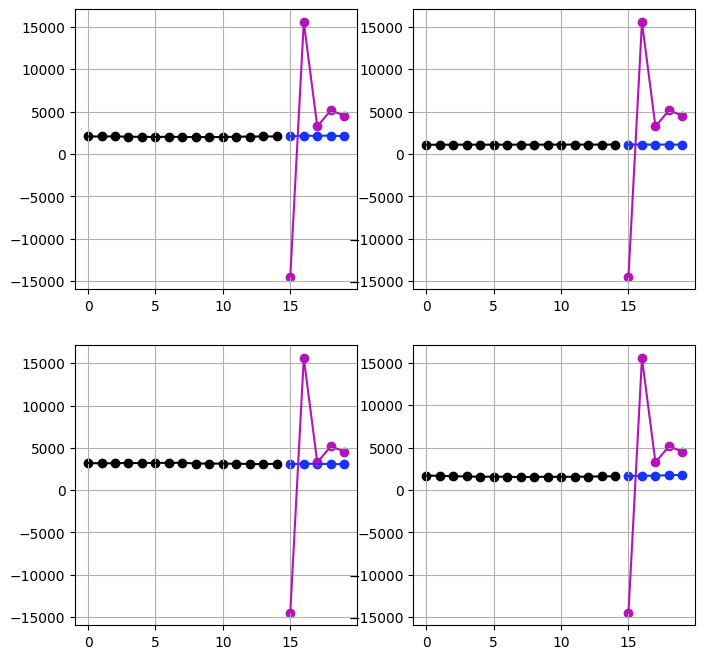

epoch = 0000, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

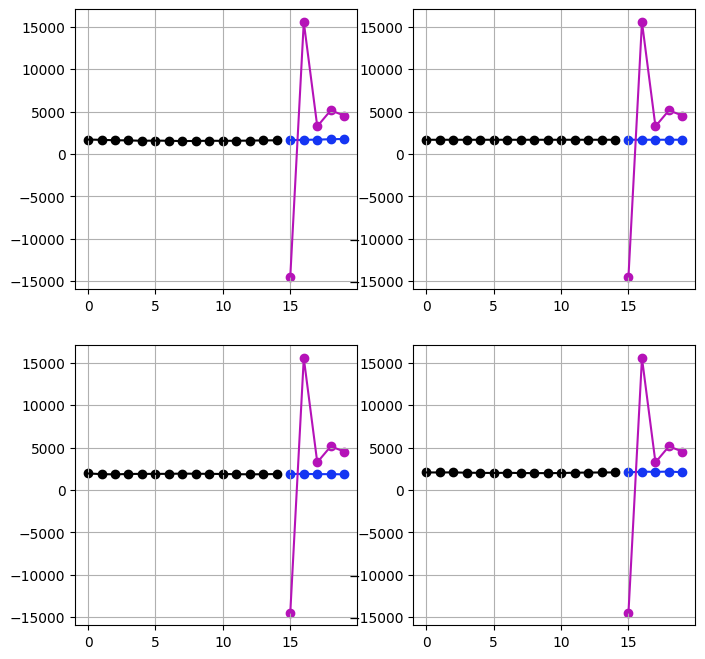

epoch = 0100, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

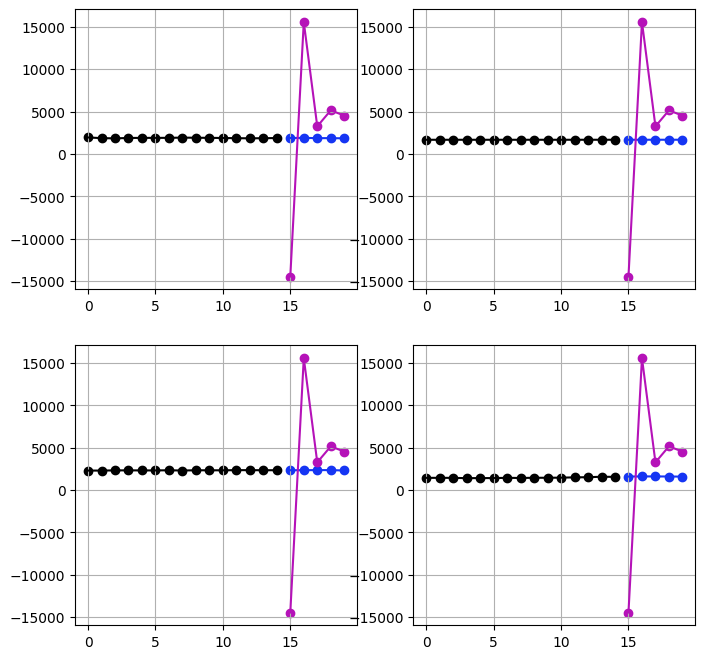

epoch = 0200, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

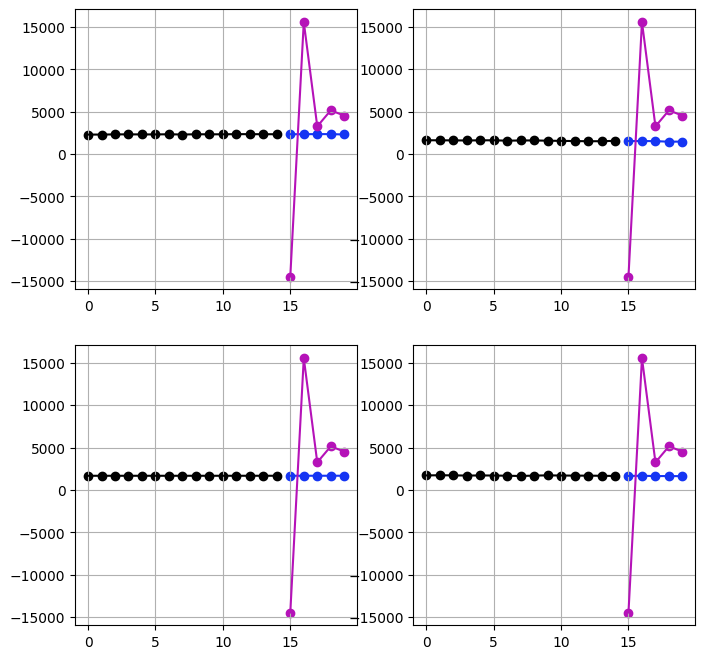

epoch = 0300, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

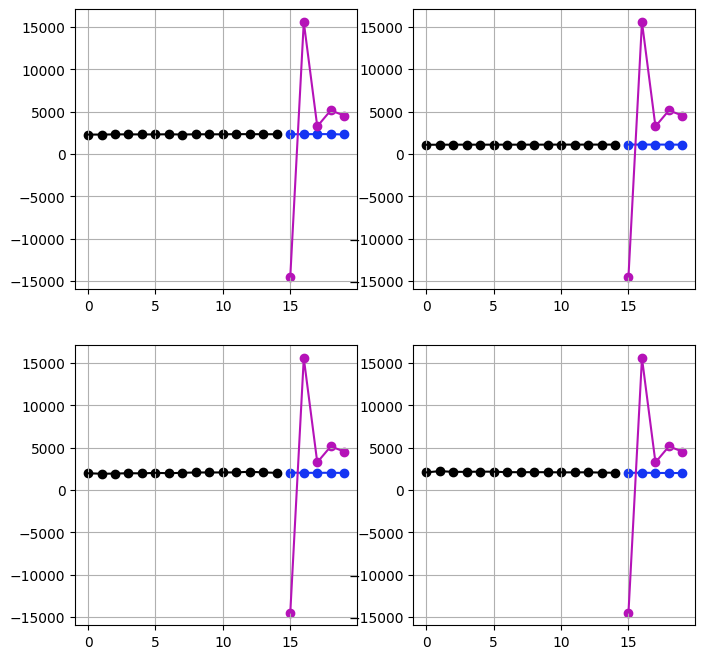

epoch = 0400, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

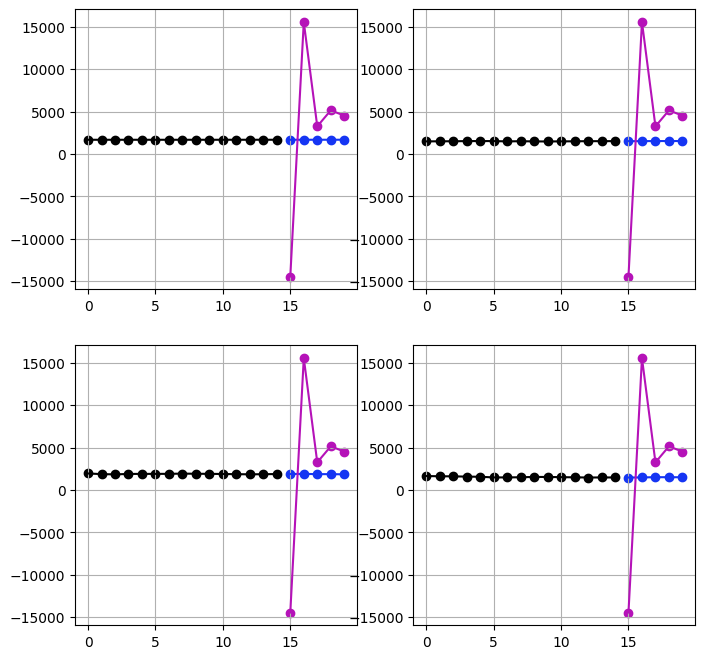

epoch = 0500, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

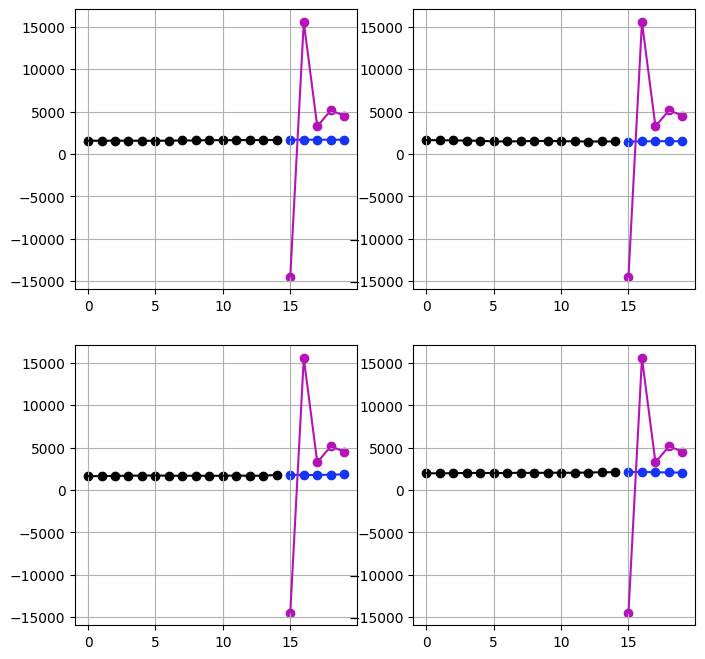

epoch = 0600, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

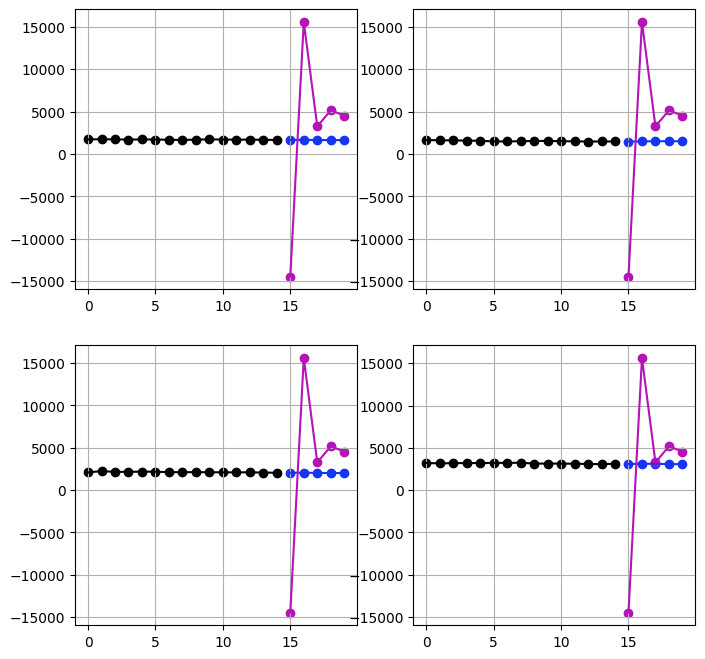

epoch = 0700, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

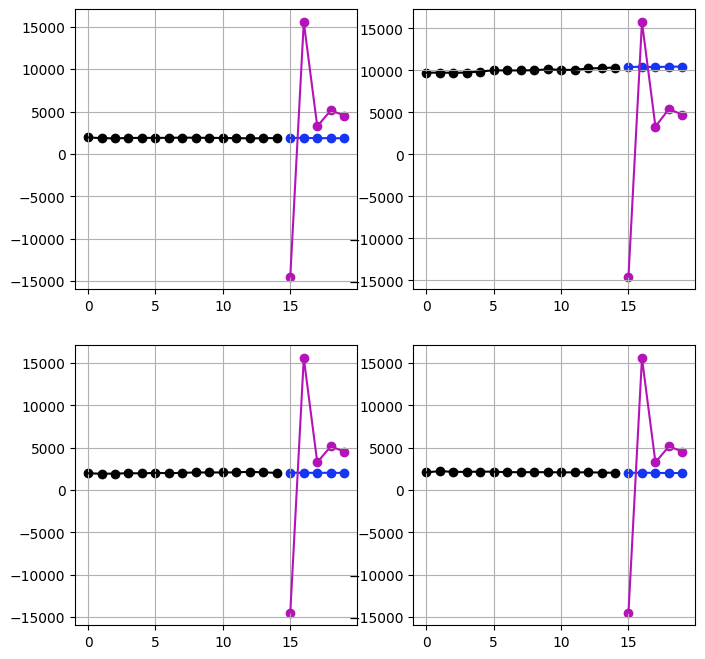

epoch = 0800, te_loss (epoch) = 382.730


<Figure size 640x480 with 0 Axes>

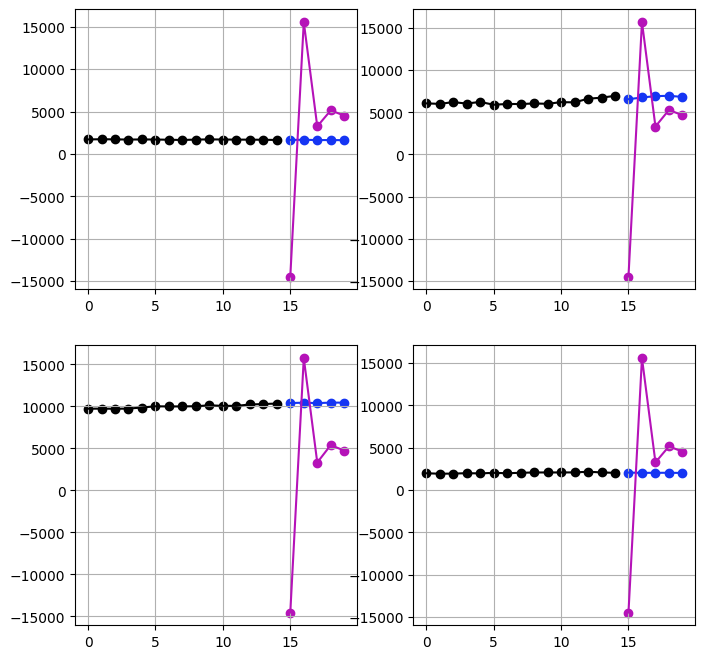

epoch = 0900, te_loss (epoch) = 382.730


In [101]:
lora.mark_only_lora_as_trainable(net_no_lora, bias='lora_only')
for epoch in range(1000):
    net_no_lora.eval()
    _, forecast = net_no_lora(torch.tensor(x_test, dtype=torch.float))
    test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
    p = forecast.detach().numpy()
    if epoch % 100 == 0:
        subplots = [221, 222, 223, 224]
        plt.figure(1)
        plt.subplots(figsize=(8, 8))
        for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
            ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
            plt.subplot(subplots[plot_id])
            plt.grid()
            plot_scatter(range(0, backcast_length), xx, color='#000000')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='#1535f3')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='#b512b8')
        plt.show()


        print(
            f'epoch = {str(epoch).zfill(4)}, '
            f'te_loss (epoch) = {1000 * test_loss:.3f}'
        )

In [102]:
pfev3 = PerformanceEvaluator(
    model=net_no_lora,
    dataset=train_dataset,
    device=device,
)

pfev3.eval()

# {'latency': 0.00108, 'throughput': 4364808.0, 'model_size': 1.219}
# {'latency': 0.00166, 'throughput': 4159606.0, 'model_size': 1.219}

Measuring throughput:  60%|██████    | 3/5 [00:00<00:00, 367.40batch/s]

Latency: 0.00105 ms/sample with batch_size 32
Throughput: 5365210.0 samples/s with batch_size 32
Model size: 1.219 MB


{'latency': 0.00105, 'throughput': 5365210.0, 'model_size': 1.219}

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/solution.svg">
>   <img alt="Solution" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/solution.svg">
> </picture><br>
>
> ### LoRALayer implentation

In [103]:
class LoRALayer():
    def __init__(
        self,
        r: int,
        lora_alpha: int,
        lora_dropout: float,
        merge_weights: bool,
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        # Optional dropout
        if lora_dropout > 0.:
            self.lora_dropout = nn.Dropout(p=lora_dropout)
        else:
            self.lora_dropout = lambda x: x
        # Mark the weight as unmerged
        self.merged = False
        self.merge_weights = merge_weights

class LinearLora(nn.Linear, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self,
        in_features: int,
        out_features: int,
        r: int = 0,
        lora_alpha: int = 1,
        lora_dropout: float = 0.,
        fan_in_fan_out: bool = False, # Set this to True if the layer to replace stores weight like (fan_in, fan_out)
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)

        self.fan_in_fan_out = fan_in_fan_out
        # Actual trainable parameters
        if r > 0:
            self.lora_A = nn.Parameter(self.weight.new_zeros((r, in_features)))
            self.lora_B = nn.Parameter(self.weight.new_zeros((out_features, r)))
            self.scaling = self.lora_alpha / self.r
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
        self.reset_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.transpose(0, 1)

    def reset_parameters(self):
        nn.Linear.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            # initialize B the same way as the default for nn.Linear and A to zero
            # this is different than what is described in the paper but should not affect performance
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)

    def train(self, mode: bool = True):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        nn.Linear.train(self, mode)
        if mode:
            if self.merge_weights and self.merged:
                # Make sure that the weights are not merged
                if self.r > 0:
                    self.weight.data -= T(self.lora_B @ self.lora_A) * self.scaling
                self.merged = False
        else:
            if self.merge_weights and not self.merged:
                # Merge the weights and mark it
                if self.r > 0:
                    self.weight.data += T(self.lora_B @ self.lora_A) * self.scaling
                self.merged = True

    def forward(self, x: torch.Tensor):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        if self.r > 0 and not self.merged:
            result = F.linear(x, T(self.weight), bias=self.bias)
            result += (self.lora_dropout(x) @ self.lora_A.transpose(0, 1) @ self.lora_B.transpose(0, 1)) * self.scaling
            return result
        else:
            return F.linear(x, T(self.weight), bias=self.bias)

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/complete.svg">
>   <img alt="Complete" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/complete.svg">
> </picture><br>
>
> ### Nbeats Lora Layers

In [104]:
class NBeatsNetLORA(nn.Module):
    SEASONALITY_BLOCK = "seasonality"
    TREND_BLOCK = "trend"
    GENERIC_BLOCK = "generic"

    def __init__(
            self,
            device=torch.device('cpu'),
            stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
            nb_blocks_per_stack=3,
            forecast_length=5,
            backcast_length=10,
            thetas_dim=(4, 8),
            share_weights_in_stack=False,
            hidden_layer_units=256,
            nb_harmonics=None
    ):
        super(NBeatsNetLORA, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dim
        self.parameters = []
        self.device = device
        print('| N-Beats Lora')
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)
        self._loss = None
        self._opt = None
        self._gen_intermediate_outputs = False
        self._intermediary_outputs = []

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNetLORA.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    self.hidden_layer_units, self.thetas_dim[stack_id],
                    self.device, self.backcast_length, self.forecast_length,
                    self.nb_harmonics
                )
                self.parameters.extend(block.parameters())
            print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    def disable_intermediate_outputs(self):
        self._gen_intermediate_outputs = False

    def enable_intermediate_outputs(self):
        self._gen_intermediate_outputs = True

    def save(self, filename: str):
        torch.save(self, filename)

    @staticmethod
    def load(f, map_location=None, pickle_module=pickle, **pickle_load_args):
        return torch.load(f, map_location, pickle_module, **pickle_load_args)

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNetLORA.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNetLORA.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def compile(self, loss: str, optimizer: Union[str, Optimizer]):
        if loss == 'mae':
            loss_ = l1_loss
        elif loss == 'mse':
            loss_ = mse_loss
        elif loss == 'cross_entropy':
            loss_ = cross_entropy
        elif loss == 'binary_crossentropy':
            loss_ = binary_cross_entropy
        else:
            raise ValueError(f'Unknown loss name: {loss}.')
        # noinspection PyArgumentList
        if isinstance(optimizer, str):
            if optimizer == 'adam':
                opt_ = optim.Adam
            elif optimizer == 'sgd':
                opt_ = optim.SGD
            elif optimizer == 'rmsprop':
                opt_ = optim.RMSprop
            else:
                raise ValueError(f'Unknown opt name: {optimizer}.')
            opt_ = opt_(lr=1e-4, params=self.parameters())
        else:
            opt_ = optimizer
        self._opt = opt_
        self._loss = loss_

    def fit(self, x_train, y_train, validation_data=None, epochs=10, batch_size=32):

        def split(arr, size):
            arrays = []
            while len(arr) > size:
                slice_ = arr[:size]
                arrays.append(slice_)
                arr = arr[size:]
            arrays.append(arr)
            return arrays

        for epoch in range(epochs):
            x_train_list = split(x_train, batch_size)
            y_train_list = split(y_train, batch_size)
            assert len(x_train_list) == len(y_train_list)
            shuffled_indices = list(range(len(x_train_list)))
            random.shuffle(shuffled_indices)
            self.train()
            train_loss = []
            timer = time()
            for batch_id in shuffled_indices:
                batch_x, batch_y = x_train_list[batch_id], y_train_list[batch_id]
                self._opt.zero_grad()
                _, forecast = self(torch.tensor(batch_x, dtype=torch.float).to(self.device))
                loss = self._loss(forecast, squeeze_last_dim(torch.tensor(batch_y, dtype=torch.float).to(self.device)))
                train_loss.append(loss.item())
                loss.backward()
                self._opt.step()
            elapsed_time = time() - timer
            train_loss = np.mean(train_loss)

            test_loss = '[undefined]'
            if validation_data is not None:
                x_test, y_test = validation_data
                self.eval()
                _, forecast = self(torch.tensor(x_test, dtype=torch.float).to(self.device))
                test_loss = self._loss(forecast, squeeze_last_dim(torch.tensor(y_test, dtype=torch.float))).item()

            num_samples = len(x_train_list)
            time_per_step = int(elapsed_time / num_samples * 1000)
            print(f'Epoch {str(epoch + 1).zfill(len(str(epochs)))}/{epochs}')
            print(f'{num_samples}/{num_samples} [==============================] - '
                  f'{int(elapsed_time)}s {time_per_step}ms/step - '
                  f'loss: {train_loss:.4f} - val_loss: {test_loss:.4f}')

    def predict(self, x, return_backcast=False):
        self.eval()
        b, f = self(torch.tensor(x, dtype=torch.float).to(self.device))
        b, f = b.detach().numpy(), f.detach().numpy()
        if len(x.shape) == 3:
            b = np.expand_dims(b, axis=-1)
            f = np.expand_dims(f, axis=-1)
        if return_backcast:
            return b
        return f

    @staticmethod
    def name():
        return 'NBeatsPytorch'

    def get_generic_and_interpretable_outputs(self):
        g_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' in a['layer'].lower()])
        i_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' not in a['layer'].lower()])
        outputs = {o['layer']: o['value'][0] for o in self._intermediary_outputs}
        return g_pred, i_pred, outputs

    def forward(self, backcast):
        self._intermediary_outputs = []
        backcast = squeeze_last_dim(backcast)
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
                block_type = self.stacks[stack_id][block_id].__class__.__name__
                layer_name = f'stack_{stack_id}-{block_type}_{block_id}'
                if self._gen_intermediate_outputs:
                    self._intermediary_outputs.append({'value': f.detach().numpy(), 'layer': layer_name})
        return backcast, forecast


def squeeze_last_dim(tensor):
    if len(tensor.shape) == 3 and tensor.shape[-1] == 1:  # (128, 10, 1) => (128, 10).
        return tensor[..., 0]
    return tensor


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor(np.array([np.cos(2 * np.pi * i * t) for i in range(p1)])).float()  # H/2-1
    s2 = torch.tensor(np.array([np.sin(2 * np.pi * i * t) for i in range(p2)])).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor(np.array([t ** i for i in range(p)])).float()
    return thetas.mm(T.to(device))


def linear_space(backcast_length, forecast_length, is_forecast=True):
    horizon = forecast_length if is_forecast else backcast_length
    return np.arange(0, horizon) / horizon


class BlockLORA(nn.Module):
    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False,
                 nb_harmonics=None):
        super(BlockLORA, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = LinearLora(backcast_length, units)
        self.fc2 = LinearLora(units, units)
        self.fc3 = LinearLora(units, units)
        self.fc4 = LinearLora(units, units)
        self.device = device
        self.backcast_linspace = linear_space(backcast_length, forecast_length, is_forecast=False)
        self.forecast_linspace = linear_space(backcast_length, forecast_length, is_forecast=True)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = LinearLora(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = LinearLora(units, thetas_dim, bias=False)
            self.theta_f_fc = LinearLora(units, thetas_dim, bias=False)

    def forward(self, x):
        x = squeeze_last_dim(x)
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlockLora(Block):
    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlockLora, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlockLora, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlockLora, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlockLora(Block):
    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlockLora, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlockLora, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class GenericBlockLora(Block):
    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(GenericBlockLora, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = LinearLora(thetas_dim, backcast_length)
        self.forecast_fc = LinearLora(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = self.theta_b_fc(x)
        theta_f = self.theta_f_fc(x)

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast

In [105]:
net_lora = NBeatsNetLORA(
    stack_types=(NBeatsNetLORA.GENERIC_BLOCK, NBeatsNetLORA.GENERIC_BLOCK),
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    hidden_layer_units=128,
)

| N-Beats Lora
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @134804119196224
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @134804119198624
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @134804119198000
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @134804119203280
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @134804119193680
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @134804119206016


<ipython-input-90-f231318e5714>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(subplots[plot_id])


<Figure size 640x480 with 0 Axes>

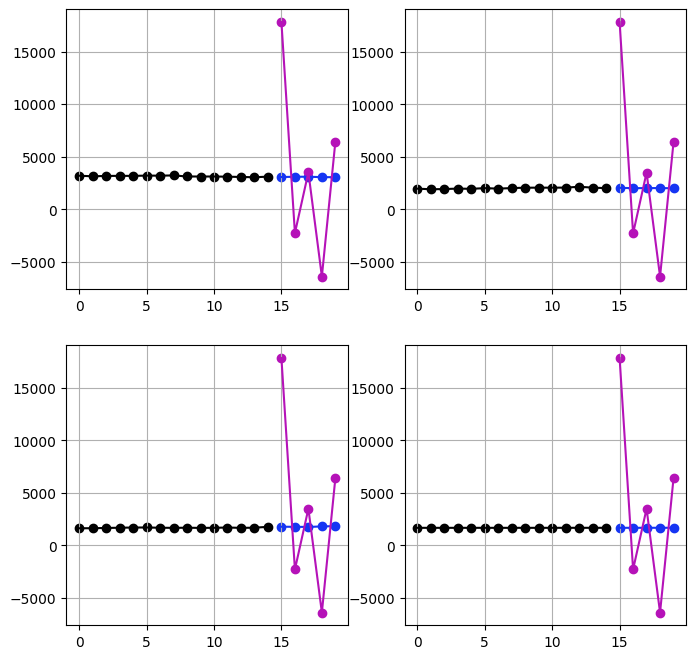

epoch = 0000, grad_step = 000008, tr_loss (epoch) = 327.574, te_loss (epoch) = 292.229


<Figure size 640x480 with 0 Axes>

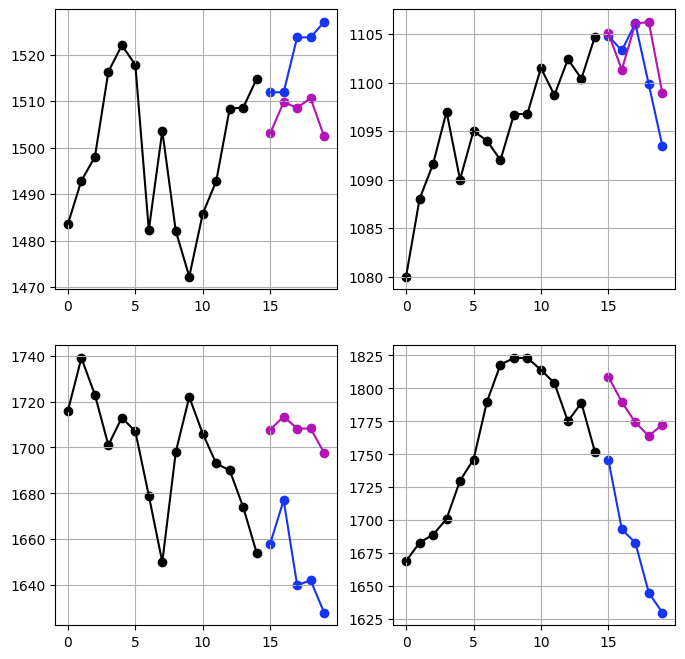

epoch = 0100, grad_step = 000808, tr_loss (epoch) = 0.080, te_loss (epoch) = 0.113


<Figure size 640x480 with 0 Axes>

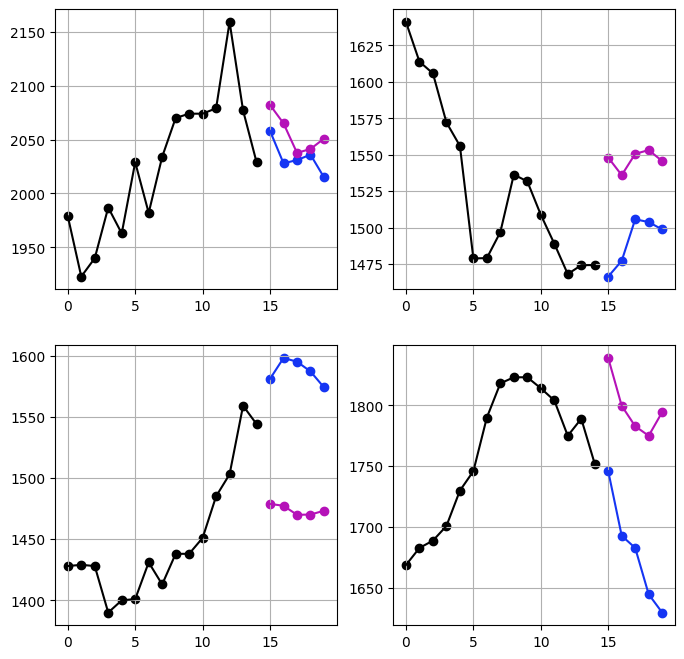

epoch = 0200, grad_step = 001608, tr_loss (epoch) = 0.071, te_loss (epoch) = 0.105


<Figure size 640x480 with 0 Axes>

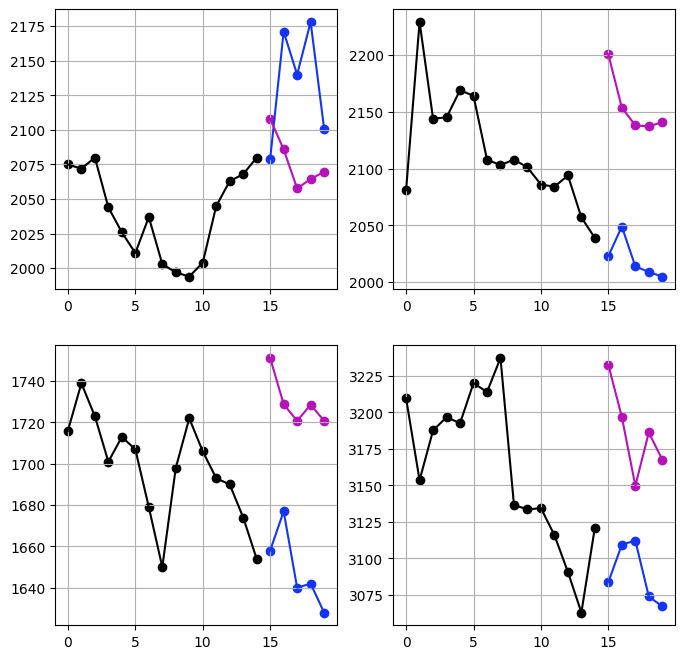

epoch = 0300, grad_step = 002408, tr_loss (epoch) = 0.070, te_loss (epoch) = 0.095


<Figure size 640x480 with 0 Axes>

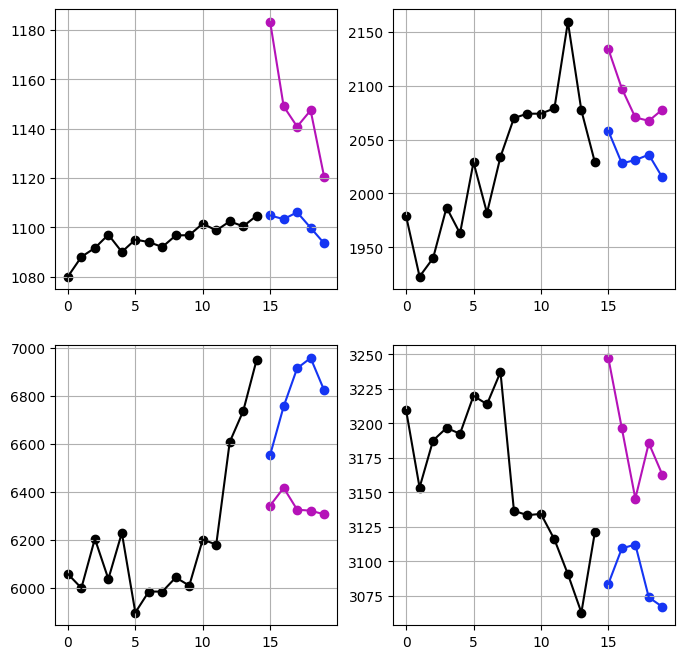

epoch = 0400, grad_step = 003208, tr_loss (epoch) = 0.069, te_loss (epoch) = 0.088


<Figure size 640x480 with 0 Axes>

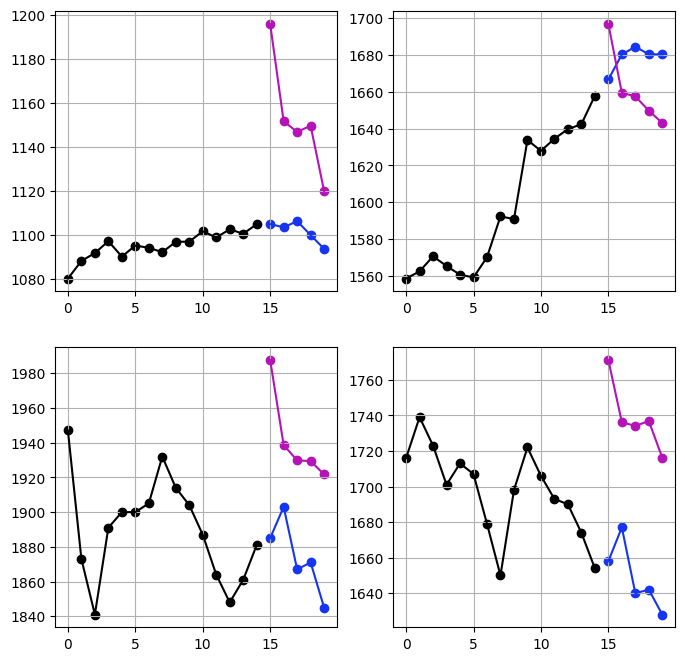

epoch = 0500, grad_step = 004008, tr_loss (epoch) = 0.066, te_loss (epoch) = 0.082


<Figure size 640x480 with 0 Axes>

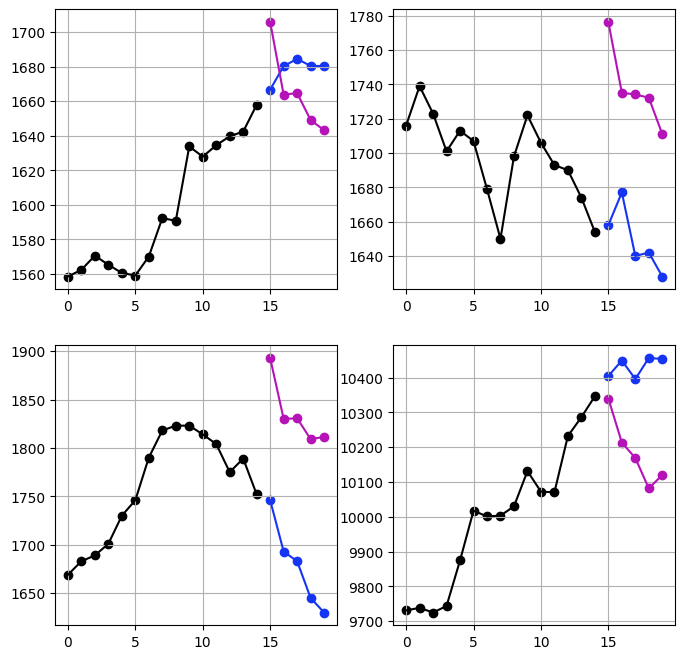

epoch = 0600, grad_step = 004808, tr_loss (epoch) = 0.062, te_loss (epoch) = 0.076


<Figure size 640x480 with 0 Axes>

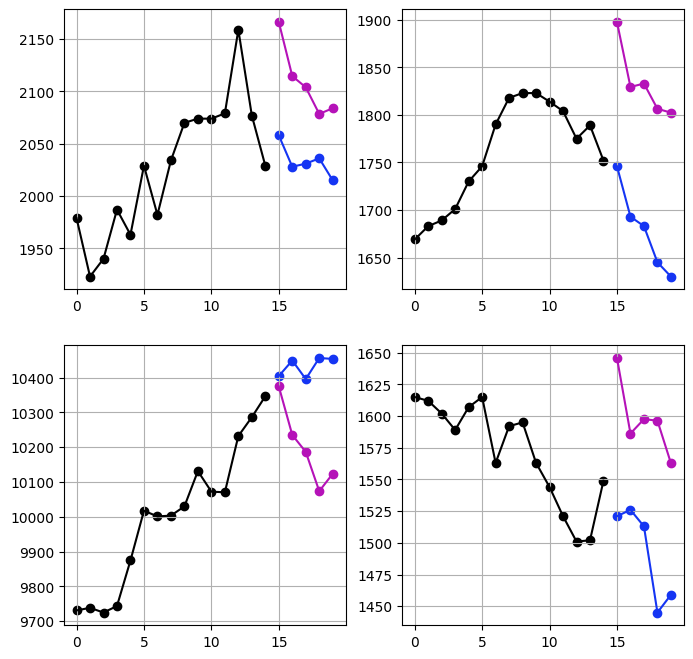

epoch = 0700, grad_step = 005608, tr_loss (epoch) = 0.058, te_loss (epoch) = 0.071


<Figure size 640x480 with 0 Axes>

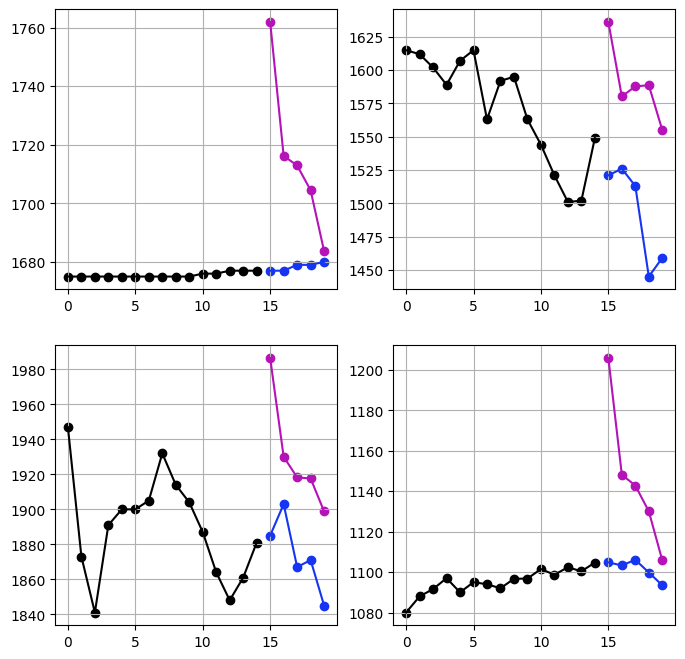

epoch = 0800, grad_step = 006408, tr_loss (epoch) = 0.053, te_loss (epoch) = 0.066


<Figure size 640x480 with 0 Axes>

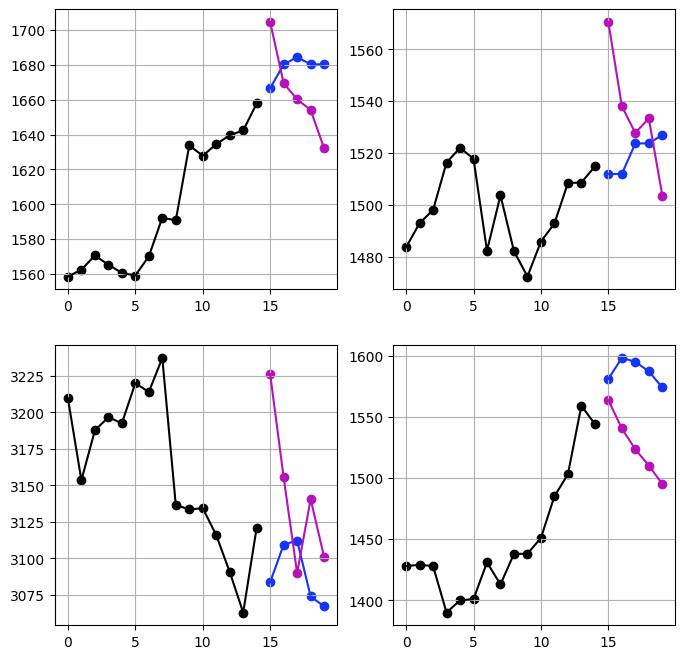

epoch = 0900, grad_step = 007208, tr_loss (epoch) = 0.050, te_loss (epoch) = 0.059


In [106]:
train(net_lora, True)

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/example.svg">
>   <img alt="Example" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/example.svg">
> </picture><br>
>
> ### Measure of metrics with lora metrics

In [107]:
pfev_lora = PerformanceEvaluator(
    model=net_lora,
    dataset=train_dataset,
    device=device,
)

pfev_lora.eval()

Measuring throughput:  60%|██████    | 3/5 [00:00<00:00, 241.57batch/s]

Latency: 0.00166 ms/sample with batch_size 32
Throughput: 4159606.0 samples/s with batch_size 32
Model size: 1.219 MB


{'latency': 0.00166, 'throughput': 4159606.0, 'model_size': 1.219}

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/success.svg">
>   <img alt="Success" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/success.svg">
> </picture><br>
>
> # Results

```
# Before
{'latency': 0.00108, 'throughput': 4364808.0, 'model_size': 1.219}
# Own Implementation
{'latency': 0.00166, 'throughput': 4159606.0, 'model_size': 1.219}
# Microsoft implementation default
{'latency': 0.00106, 'throughput': 4748564.0, 'model_size': 1.219}
# Microsoft implementation all
{'latency': 0.00108, 'throughput': 4482670.0, 'model_size': 1.219}
# Microsoft implementation lora_only
{'latency': 0.00105, 'throughput': 5365210.0, 'model_size': 1.219}
```

